<a href="https://colab.research.google.com/github/cohitai/AI_notebooks/blob/main/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational AutoEncoder = (encoder= Recognition model, decoder=Generative model)+ Variational loss.



In [1]:
#ToDO: visualizations of the latent space, KL divergence explanations, Generative data. 
### Go over these: 
# Not sure I have the "right" variational loss. 
# https://avandekleut.github.io/vae/
# https://www.jeremyjordan.me/variational-autoencoders/
# https://gaussian37.github.io/deep-learning-chollet-8-4/
# simplify NN ? (How many ResNet layers/Blocks? are actiually meaningfull for a baseline.)
# output doesn't converge well. (check loss ? epochs adjustments/learning rate?)
# plot the loss


# The loss depends heavily on the BS. 
# Compare the loss in the pretrained VAE model. 


In [2]:
!nvidia-smi

Mon Nov 14 11:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## download cifar10 data

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

--2022-11-14 11:42:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  86.9MB/s    in 1.9s    

2022-11-14 11:42:19 (86.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [5]:
!ls

cifar-10-python.tar.gz	sample_data


In [6]:
!tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
!ls -al cifar-10-batches-py

total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 1 root root     4096 Nov 14 11:42 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [12]:
import os.path as osp
path = "./cifar-10-batches-py"
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

!ls $path

c10_data = unpickle(osp.join(path,"data_batch_1"))
print(c10_data.keys())

# extract c10 data --> images,labels
images = c10_data[b"data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") # (10000,3072)
labels = c10_data[b"labels"]
#
print("Data Shape",images.shape)

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Shape (10000, 32, 32, 3)


In [13]:
from torch import nn
import torch.nn.functional as F
import torch 
import math
from tqdm import trange

device="cuda"

class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0, 
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_downsample=True,
        downsample_padding=1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        in_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states
    
class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        non_linearity="swish",
        time_embedding_norm="default",
        kernel=None,
        output_scale_factor=1.0,
        use_nin_shortcut=None,
        up=False,
        down=False,
    ):
        super().__init__()
        self.pre_norm = pre_norm
        self.pre_norm = True
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut
        self.time_embedding_norm = time_embedding_norm
        self.up = up
        self.down = down
        self.output_scale_factor = output_scale_factor

        if groups_out is None:
            groups_out = groups

        self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if temb_channels is not None:
            self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if non_linearity == "swish":
            self.nonlinearity = lambda x: F.silu(x)
        elif non_linearity == "mish":
            self.nonlinearity = Mish()
        elif non_linearity == "silu":
            self.nonlinearity = nn.SiLU()

        self.upsample = self.downsample = None
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")

        self.use_nin_shortcut = self.in_channels != self.out_channels if use_nin_shortcut is None else use_nin_shortcut

        self.conv_shortcut = None
    
        if self.use_nin_shortcut:
            self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb, hey=False):
        h = x

        # print("LOG resnet_input",h.size())

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm1(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        # if self.upsample is not None:
        #     x = self.upsample(x)
        #     h = self.upsample(h)
        # elif self.downsample is not None:
        #     x = self.downsample(x)
        #     h = self.downsample(h)

        h = self.conv1(h)

        # print("LOG temb:",temb is None)

        # if temb is not None:
        #     temb = self.time_emb_proj(self.nonlinearity(temb))[:, :, None, None]
        #     h = h + temb

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm2(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        h = self.dropout(h)
        h = self.conv2(h)

        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)

        out = (x + h) / self.output_scale_factor

        return out

    def set_weight(self, resnet):
        self.norm1.weight.data = resnet.norm1.weight.data
        self.norm1.bias.data = resnet.norm1.bias.data

        self.conv1.weight.data = resnet.conv1.weight.data
        self.conv1.bias.data = resnet.conv1.bias.data

        if self.time_emb_proj is not None:
            self.time_emb_proj.weight.data = resnet.temb_proj.weight.data
            self.time_emb_proj.bias.data = resnet.temb_proj.bias.data

        self.norm2.weight.data = resnet.norm2.weight.data
        self.norm2.bias.data = resnet.norm2.bias.data

        self.conv2.weight.data = resnet.conv2.weight.data
        self.conv2.bias.data = resnet.conv2.bias.data

        if self.use_nin_shortcut:
            self.conv_shortcut.weight.data = resnet.nin_shortcut.weight.data
            self.conv_shortcut.bias.data = resnet.nin_shortcut.bias.data
            
            
class Downsample2D(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, out_channels=None, padding=1, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.padding = padding
        stride = 2
        self.name = name

        if use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.Conv2d_0 = conv
            self.conv = conv
        elif name == "Conv2d_0":
            self.conv = conv
        else:
            self.conv = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv and self.padding == 0:
            pad = (0, 1, 0, 1)
            x = F.pad(x, pad, mode="constant", value=0)

        assert x.shape[1] == self.channels
        x = self.conv(x)

        # print('LOG',x)
        return x


class AttentionBlockNew(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other. Originally ported from here, but adapted
    to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    Uses three q, k, v linear layers to compute attention
    """

    def __init__(
        self,
        channels,
        num_head_channels=None,
        num_groups=32,
        rescale_output_factor=1.0,
        eps=1e-5,
    ):
        super().__init__()
        self.channels = channels

        self.num_heads = channels // num_head_channels if num_head_channels is not None else 1
        self.num_head_size = num_head_channels
        self.group_norm = nn.GroupNorm(num_channels=channels, num_groups=num_groups, eps=eps, affine=True)

        # define q,k,v as linear layers
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)

        self.rescale_output_factor = rescale_output_factor
        self.proj_attn = nn.Linear(channels, channels, 1)

    def transpose_for_scores(self, projection: torch.Tensor) -> torch.Tensor:
        new_projection_shape = projection.size()[:-1] + (self.num_heads, -1)
        # move heads to 2nd position (B, T, H * D) -> (B, T, H, D) -> (B, H, T, D)
        new_projection = projection.view(new_projection_shape).permute(0, 2, 1, 3)
        return new_projection

    def forward(self, hidden_states):
        residual = hidden_states
        batch, channel, height, width = hidden_states.shape

        # norm
        hidden_states = self.group_norm(hidden_states)

        hidden_states = hidden_states.view(batch, channel, height * width).transpose(1, 2)

        # proj to q, k, v
        query_proj = self.query(hidden_states)
        key_proj = self.key(hidden_states)
        value_proj = self.value(hidden_states)

        # transpose
        query_states = self.transpose_for_scores(query_proj)
        key_states = self.transpose_for_scores(key_proj)
        value_states = self.transpose_for_scores(value_proj)

        # get scores
        scale = 1 / math.sqrt(math.sqrt(self.channels / self.num_heads))
        attention_scores = torch.matmul(query_states * scale, key_states.transpose(-1, -2) * scale)
        attention_probs = torch.softmax(attention_scores.float(), dim=-1).type(attention_scores.dtype)

        # compute attention output
        context_states = torch.matmul(attention_probs, value_states)

        context_states = context_states.permute(0, 2, 1, 3).contiguous()
        new_context_states_shape = context_states.size()[:-2] + (self.channels,)
        context_states = context_states.view(new_context_states_shape)

        # compute next hidden_states
        hidden_states = self.proj_attn(context_states)
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch, channel, height, width)

        # res connect and rescale
        hidden_states = (hidden_states + residual) / self.rescale_output_factor
        return hidden_states

    def set_weight(self, attn_layer):
        self.group_norm.weight.data = attn_layer.norm.weight.data
        self.group_norm.bias.data = attn_layer.norm.bias.data

        if hasattr(attn_layer, "q"):
            self.query.weight.data = attn_layer.q.weight.data[:, :, 0, 0]
            self.key.weight.data = attn_layer.k.weight.data[:, :, 0, 0]
            self.value.weight.data = attn_layer.v.weight.data[:, :, 0, 0]

            self.query.bias.data = attn_layer.q.bias.data
            self.key.bias.data = attn_layer.k.bias.data
            self.value.bias.data = attn_layer.v.bias.data

            self.proj_attn.weight.data = attn_layer.proj_out.weight.data[:, :, 0, 0]
            self.proj_attn.bias.data = attn_layer.proj_out.bias.data
        elif hasattr(attn_layer, "NIN_0"):
            self.query.weight.data = attn_layer.NIN_0.W.data.T
            self.key.weight.data = attn_layer.NIN_1.W.data.T
            self.value.weight.data = attn_layer.NIN_2.W.data.T

            self.query.bias.data = attn_layer.NIN_0.b.data
            self.key.bias.data = attn_layer.NIN_1.b.data
            self.value.bias.data = attn_layer.NIN_2.b.data

            self.proj_attn.weight.data = attn_layer.NIN_3.W.data.T
            self.proj_attn.bias.data = attn_layer.NIN_3.b.data

            self.group_norm.weight.data = attn_layer.GroupNorm_0.weight.data
            self.group_norm.bias.data = attn_layer.GroupNorm_0.bias.data
        else:
            qkv_weight = attn_layer.qkv.weight.data.reshape(
                self.num_heads, 3 * self.channels // self.num_heads, self.channels
            )
            qkv_bias = attn_layer.qkv.bias.data.reshape(self.num_heads, 3 * self.channels // self.num_heads)

            q_w, k_w, v_w = qkv_weight.split(self.channels // self.num_heads, dim=1)
            q_b, k_b, v_b = qkv_bias.split(self.channels // self.num_heads, dim=1)

            self.query.weight.data = q_w.reshape(-1, self.channels)
            self.key.weight.data = k_w.reshape(-1, self.channels)
            self.value.weight.data = v_w.reshape(-1, self.channels)

            self.query.bias.data = q_b.reshape(-1)
            self.key.bias.data = k_b.reshape(-1)
            self.value.bias.data = v_b.reshape(-1)

            self.proj_attn.weight.data = attn_layer.proj.weight.data[:, :, 0]
            self.proj_attn.bias.data = attn_layer.proj.bias.data

class UNetMidBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attn_num_head_channels=1,
        attention_type="default",
        output_scale_factor=1.0,
        **kwargs,
    ):
        super().__init__()

        self.attention_type = attention_type
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # there is always at least one resnet
        resnets = [
            ResnetBlock(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            attentions.append(
                AttentionBlockNew(
                    in_channels,
                    num_head_channels=attn_num_head_channels,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    num_groups=resnet_groups,
                )
            )
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states, temb=None, encoder_states=None):
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.attention_type == "default":
                hidden_states = attn(hidden_states)
            else:
                hidden_states = attn(hidden_states, encoder_states)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True,
    ):
        super().__init__()
        self.layers_per_block = layers_per_block
        self.conv_in = torch.nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, stride=1, padding=1)
        self.mid_block = None
        self.down_blocks = nn.ModuleList([])

        # down
        output_channel = block_out_channels[0]
        for i, _ in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = DownEncoderBlock2D(
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                downsample_padding=0,)

            self.down_blocks.append(down_block)

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * out_channels if double_z else out_channels
        self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

    def forward(self, x):
        
        sample = x
        sample = self.conv_in(sample)
        
        # down
        for down_block in self.down_blocks:
            sample = down_block(sample)

        # middle
        sample = self.mid_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample


class Decoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        up_block_types=("UpDecoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=2,
        act_fn="silu",
    ):
        super().__init__()
        self.layers_per_block = layers_per_block

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[-1], kernel_size=3, stride=1, padding=1)

        self.mid_block = None
        self.up_blocks = nn.ModuleList([])

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]

            is_final_block = i == len(block_out_channels) - 1

            up_block = UpDecoderBlock2D(
            num_layers=self.layers_per_block + 1,
            in_channels=prev_output_channel,
            out_channels=output_channel,
            add_upsample=not is_final_block,
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
        )

            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

    def forward(self, z):
        sample = z
        sample = self.conv_in(sample)

        # middle
        sample = self.mid_block(sample)

        # up
        for up_block in self.up_blocks:
            sample = up_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample
    

class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_upsample=True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            resnets.append(
                ResnetBlock(
                    in_channels=input_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states


class Upsample2D(nn.Module):

    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, use_conv_transpose=False, out_channels=None, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_conv_transpose = use_conv_transpose
        self.name = name

        conv = None
        if use_conv_transpose:
            conv = nn.ConvTranspose2d(channels, self.out_channels, 4, 2, 1)
        elif use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.conv = conv
        else:
            self.Conv2d_0 = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv_transpose:
            return self.conv(x)

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if self.use_conv:
            if self.name == "conv":
                x = self.conv(x)
            else:
                x = self.Conv2d_0(x)

        return x

In [58]:
# from models import Encoder, Decoder

from dataclasses import dataclass
from dataclasses import fields
import torch
import torch.nn as nn
import numpy as np

import os

print("Working directory:", os.getcwd())

class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=dims)

    def mode(self):
        return self.mean



encoder = Encoder(in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True)


decoder = Decoder(in_channels=4,
            out_channels=3,
            up_block_types=("UpDecoderBlock2D",),
            block_out_channels=(64,),
            layers_per_block=1,
            act_fn="silu")

    ##########################
    ##########################
    ##########################
#### AutoEncoder wrap- up class ####
    ##########################
    ##########################
    ##########################

class AutoencoderKL(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
        up_block_types=("UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D",),
        block_out_channels=(128, 256, 512, 512,),
        layers_per_block=2,
        act_fn="silu",
        latent_channels=4,
        sample_size=512,
    ):
        super().__init__()

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1) 
        self.kl = 0

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, sample, sample_posterior=False):
        x = sample
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        self.kl=posterior.kl()
        return dec


# for param in encoder.parameters():
#   print(param.data)

def adjust(sample):
    # sample=np.expand_dims(np.asarray(sample), axis=0)
    sample=sample.numpy()/ 255.0
    # sample=sample.astype('float32')
    sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
    sample = 2 * (sample - 0.5) # values between (-1, 1)
    return sample
    

##### train

from tqdm import tqdm
PATH = './vae_net.pth'
losses=[]
def train(autoencoder, data, epochs=20):
    
    global opt
    opt = torch.optim.Adam(autoencoder.parameters())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    epoch = 0

    if os.path.exists(PATH):
      checkpoint = torch.load(PATH)
      autoencoder.load_state_dict(checkpoint['model_state_dict'])
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      epoch = checkpoint['epoch']
      loss = checkpoint['loss']

    for epoch in range(epoch, epochs):
        print("Log epoch:",epoch)
        for i,x in enumerate(tqdm(data,total=len(data))):
            x=adjust(x[0])
            x = torch.Tensor(x).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.kl.sum()
            loss.backward()
            opt.step()
            loss=loss.item()
            losses.append(loss)
            print(loss)

            if not i % 50 and i !=0: 
                torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss}, PATH)
                print("model saved!")
        scheduler.step()
        torch.save(autoencoder.state_dict(), PATH)
    return autoencoder








Working directory: /content


In [61]:
import torchvision
data = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)

print("data size:",next(iter(data))[0].size())

Files already downloaded and verified
data size: torch.Size([32, 3, 32, 32])


Training Variational AutoEncoder on Cifar10 data.

In [ ]:
vae=AutoencoderKL().to(device)
vae = train(vae, data,epochs=1)

Log epoch: 0


  0%|          | 1/1563 [00:00<09:11,  2.83it/s]

40.116641998291016


  0%|          | 2/1563 [00:00<08:11,  3.18it/s]

39.72080993652344


  0%|          | 3/1563 [00:00<07:52,  3.30it/s]

39.400848388671875


  0%|          | 4/1563 [00:01<07:43,  3.36it/s]

39.4824333190918


  0%|          | 5/1563 [00:01<07:38,  3.40it/s]

39.184837341308594


  0%|          | 6/1563 [00:01<07:35,  3.42it/s]

39.04882049560547


  0%|          | 7/1563 [00:02<07:33,  3.43it/s]

38.770782470703125


  1%|          | 8/1563 [00:02<07:31,  3.44it/s]

38.59699630737305


  1%|          | 9/1563 [00:02<07:29,  3.46it/s]

38.37006378173828


  1%|          | 10/1563 [00:02<07:30,  3.45it/s]

38.02840042114258


  1%|          | 11/1563 [00:03<07:29,  3.45it/s]

37.831050872802734


  1%|          | 12/1563 [00:03<07:28,  3.46it/s]

37.67258834838867


  1%|          | 13/1563 [00:03<07:28,  3.46it/s]

37.44208526611328


  1%|          | 14/1563 [00:04<07:28,  3.45it/s]

37.24844741821289


  1%|          | 15/1563 [00:04<07:28,  3.45it/s]

37.0069465637207


  1%|          | 16/1563 [00:04<07:27,  3.46it/s]

36.83150100708008


  1%|          | 17/1563 [00:04<07:26,  3.46it/s]

36.52648162841797


  1%|          | 18/1563 [00:05<07:25,  3.47it/s]

36.40243148803711


  1%|          | 19/1563 [00:05<07:25,  3.46it/s]

36.20183563232422


  1%|▏         | 20/1563 [00:05<07:25,  3.46it/s]

36.11247634887695


  1%|▏         | 21/1563 [00:06<07:25,  3.46it/s]

35.812740325927734


  1%|▏         | 22/1563 [00:06<07:25,  3.46it/s]

35.624359130859375


  1%|▏         | 23/1563 [00:06<07:25,  3.46it/s]

35.412269592285156


  2%|▏         | 24/1563 [00:07<07:26,  3.45it/s]

35.31307601928711


  2%|▏         | 25/1563 [00:07<07:25,  3.46it/s]

35.19780731201172


  2%|▏         | 26/1563 [00:07<07:24,  3.46it/s]

34.90706253051758


  2%|▏         | 27/1563 [00:07<07:24,  3.46it/s]

34.696983337402344


  2%|▏         | 28/1563 [00:08<07:24,  3.45it/s]

34.49873733520508


  2%|▏         | 29/1563 [00:08<07:24,  3.45it/s]

34.29115676879883


  2%|▏         | 30/1563 [00:08<07:24,  3.45it/s]

34.13373947143555


  2%|▏         | 31/1563 [00:09<07:23,  3.45it/s]

33.841556549072266


  2%|▏         | 32/1563 [00:09<07:23,  3.45it/s]

33.937625885009766


  2%|▏         | 33/1563 [00:09<07:24,  3.44it/s]

33.61320495605469


  2%|▏         | 34/1563 [00:09<07:23,  3.45it/s]

33.42755889892578


  2%|▏         | 35/1563 [00:10<07:23,  3.44it/s]

33.49703598022461


  2%|▏         | 36/1563 [00:10<07:24,  3.44it/s]

33.175838470458984


  2%|▏         | 37/1563 [00:10<07:23,  3.44it/s]

32.95292282104492


  2%|▏         | 38/1563 [00:11<07:23,  3.44it/s]

32.69709396362305


  2%|▏         | 39/1563 [00:11<07:23,  3.44it/s]

32.636207580566406


  3%|▎         | 40/1563 [00:11<07:22,  3.44it/s]

32.57368850708008


  3%|▎         | 41/1563 [00:11<07:22,  3.44it/s]

32.31665802001953


  3%|▎         | 42/1563 [00:12<07:22,  3.44it/s]

32.099098205566406


  3%|▎         | 43/1563 [00:12<07:21,  3.44it/s]

31.999723434448242


  3%|▎         | 44/1563 [00:12<07:20,  3.45it/s]

31.847993850708008


  3%|▎         | 45/1563 [00:13<07:20,  3.44it/s]

31.836666107177734


  3%|▎         | 46/1563 [00:13<07:20,  3.45it/s]

31.352697372436523


  3%|▎         | 47/1563 [00:13<07:20,  3.44it/s]

31.414770126342773


  3%|▎         | 48/1563 [00:13<07:19,  3.45it/s]

31.1455135345459


  3%|▎         | 49/1563 [00:14<07:19,  3.44it/s]

30.960433959960938


  3%|▎         | 50/1563 [00:14<07:19,  3.44it/s]

30.883926391601562
30.650182723999023


  3%|▎         | 51/1563 [00:18<36:00,  1.43s/it]

model saved!, i= 50


  3%|▎         | 52/1563 [00:19<28:03,  1.11s/it]

30.551759719848633


  3%|▎         | 53/1563 [00:19<21:50,  1.15it/s]

30.354991912841797


  3%|▎         | 54/1563 [00:19<17:29,  1.44it/s]

30.32854461669922


  4%|▎         | 55/1563 [00:19<14:25,  1.74it/s]

30.053241729736328


  4%|▎         | 56/1563 [00:20<12:16,  2.04it/s]

30.142112731933594


  4%|▎         | 57/1563 [00:20<10:47,  2.33it/s]

29.914939880371094


  4%|▎         | 58/1563 [00:20<09:44,  2.58it/s]

29.637657165527344


  4%|▍         | 59/1563 [00:21<08:59,  2.79it/s]

29.5731258392334


  4%|▍         | 60/1563 [00:21<08:31,  2.94it/s]

29.378768920898438


  4%|▍         | 61/1563 [00:21<08:09,  3.07it/s]

29.31236457824707


  4%|▍         | 62/1563 [00:21<07:53,  3.17it/s]

28.97032356262207


  4%|▍         | 63/1563 [00:22<07:42,  3.25it/s]

28.93800926208496


  4%|▍         | 64/1563 [00:22<07:33,  3.30it/s]

28.720687866210938


  4%|▍         | 65/1563 [00:22<07:28,  3.34it/s]

28.669029235839844


  4%|▍         | 66/1563 [00:23<07:25,  3.36it/s]

28.511688232421875


  4%|▍         | 67/1563 [00:23<07:24,  3.37it/s]

28.333810806274414


  4%|▍         | 68/1563 [00:23<07:21,  3.38it/s]

28.202104568481445


  4%|▍         | 69/1563 [00:23<07:19,  3.40it/s]

28.05117416381836


  4%|▍         | 70/1563 [00:24<07:18,  3.41it/s]

27.931873321533203


  5%|▍         | 71/1563 [00:24<07:18,  3.40it/s]

27.8388729095459


  5%|▍         | 72/1563 [00:24<07:17,  3.41it/s]

27.694580078125


  5%|▍         | 73/1563 [00:25<07:16,  3.41it/s]

27.46155548095703


  5%|▍         | 74/1563 [00:25<07:16,  3.41it/s]

27.44005012512207


  5%|▍         | 75/1563 [00:25<07:16,  3.41it/s]

27.36968231201172


  5%|▍         | 76/1563 [00:26<07:17,  3.40it/s]

27.040630340576172


  5%|▍         | 77/1563 [00:26<07:16,  3.40it/s]

26.998708724975586


  5%|▍         | 78/1563 [00:26<07:15,  3.41it/s]

26.946386337280273


  5%|▌         | 79/1563 [00:26<07:14,  3.42it/s]

26.798397064208984


  5%|▌         | 80/1563 [00:27<07:13,  3.42it/s]

26.59018325805664


  5%|▌         | 81/1563 [00:27<07:13,  3.42it/s]

26.504150390625


  5%|▌         | 82/1563 [00:27<07:13,  3.41it/s]

26.30232048034668


  5%|▌         | 83/1563 [00:28<07:13,  3.41it/s]

26.392704010009766


  5%|▌         | 84/1563 [00:28<07:13,  3.41it/s]

26.092811584472656


  5%|▌         | 85/1563 [00:28<07:11,  3.42it/s]

26.238853454589844


  6%|▌         | 86/1563 [00:28<07:11,  3.42it/s]

25.874408721923828


  6%|▌         | 87/1563 [00:29<07:11,  3.42it/s]

26.076547622680664


  6%|▌         | 88/1563 [00:29<07:12,  3.41it/s]

25.919193267822266


  6%|▌         | 89/1563 [00:29<07:12,  3.41it/s]

25.472558975219727


  6%|▌         | 90/1563 [00:30<07:13,  3.40it/s]

25.460546493530273


  6%|▌         | 91/1563 [00:30<07:12,  3.41it/s]

25.21424674987793


  6%|▌         | 92/1563 [00:30<07:11,  3.41it/s]

25.155715942382812


  6%|▌         | 93/1563 [00:31<07:10,  3.41it/s]

24.939136505126953


  6%|▌         | 94/1563 [00:31<07:10,  3.41it/s]

24.87852668762207


  6%|▌         | 95/1563 [00:31<07:11,  3.41it/s]

24.816707611083984


  6%|▌         | 96/1563 [00:31<07:10,  3.41it/s]

24.702781677246094


  6%|▌         | 97/1563 [00:32<07:10,  3.41it/s]

24.496431350708008


  6%|▋         | 98/1563 [00:32<07:09,  3.41it/s]

24.335111618041992


  6%|▋         | 99/1563 [00:32<07:08,  3.41it/s]

24.228958129882812


  6%|▋         | 100/1563 [00:33<07:08,  3.41it/s]

24.114898681640625
23.927200317382812


  6%|▋         | 101/1563 [00:36<33:40,  1.38s/it]

model saved!, i= 100


  7%|▋         | 102/1563 [00:37<26:09,  1.07s/it]

23.937955856323242


  7%|▋         | 103/1563 [00:37<20:29,  1.19it/s]

23.832199096679688


  7%|▋         | 104/1563 [00:37<16:27,  1.48it/s]

23.674182891845703


  7%|▋         | 105/1563 [00:38<13:37,  1.78it/s]

23.552600860595703


  7%|▋         | 106/1563 [00:38<11:40,  2.08it/s]

23.45389175415039


  7%|▋         | 107/1563 [00:38<10:17,  2.36it/s]

23.25037384033203


  7%|▋         | 108/1563 [00:39<09:31,  2.55it/s]

23.317136764526367


  7%|▋         | 109/1563 [00:39<08:52,  2.73it/s]

23.117055892944336


  7%|▋         | 110/1563 [00:39<08:34,  2.82it/s]

22.977827072143555


  7%|▋         | 111/1563 [00:40<08:31,  2.84it/s]

22.845901489257812


  7%|▋         | 112/1563 [00:40<08:06,  2.98it/s]

22.74678611755371


  7%|▋         | 113/1563 [00:40<07:48,  3.10it/s]

22.77452278137207


  7%|▋         | 114/1563 [00:41<07:43,  3.13it/s]

22.583494186401367


  7%|▋         | 115/1563 [00:41<07:37,  3.17it/s]

22.488445281982422


  7%|▋         | 116/1563 [00:41<07:33,  3.19it/s]

22.429035186767578


  7%|▋         | 117/1563 [00:41<07:28,  3.22it/s]

22.21261215209961


  8%|▊         | 118/1563 [00:42<07:35,  3.17it/s]

22.0758056640625


  8%|▊         | 119/1563 [00:42<07:38,  3.15it/s]

22.17530059814453


  8%|▊         | 120/1563 [00:42<07:52,  3.06it/s]

21.927539825439453


  8%|▊         | 121/1563 [00:43<07:37,  3.15it/s]

22.541362762451172


  8%|▊         | 122/1563 [00:43<07:26,  3.23it/s]

22.405628204345703


  8%|▊         | 123/1563 [00:43<07:19,  3.27it/s]

21.58778190612793


  8%|▊         | 124/1563 [00:44<07:15,  3.31it/s]

21.663558959960938


  8%|▊         | 125/1563 [00:44<07:10,  3.34it/s]

21.38011360168457


  8%|▊         | 126/1563 [00:44<07:07,  3.36it/s]

21.50619125366211


  8%|▊         | 127/1563 [00:44<07:06,  3.37it/s]

21.531225204467773


  8%|▊         | 128/1563 [00:45<07:04,  3.38it/s]

21.167461395263672


  8%|▊         | 129/1563 [00:45<07:03,  3.39it/s]

21.11383819580078


  8%|▊         | 130/1563 [00:45<07:03,  3.38it/s]

20.963533401489258


  8%|▊         | 131/1563 [00:46<07:01,  3.40it/s]

20.761917114257812


  8%|▊         | 132/1563 [00:46<07:01,  3.40it/s]

20.7891902923584


  9%|▊         | 133/1563 [00:46<07:00,  3.40it/s]

20.4923038482666


  9%|▊         | 134/1563 [00:47<06:59,  3.41it/s]

20.681716918945312


  9%|▊         | 135/1563 [00:47<06:58,  3.42it/s]

20.523664474487305


  9%|▊         | 136/1563 [00:47<06:58,  3.41it/s]

20.28262710571289


  9%|▉         | 137/1563 [00:47<06:58,  3.41it/s]

20.464584350585938


  9%|▉         | 138/1563 [00:48<06:57,  3.42it/s]

20.358800888061523


  9%|▉         | 139/1563 [00:48<06:58,  3.40it/s]

19.992794036865234


  9%|▉         | 140/1563 [00:48<06:58,  3.40it/s]

20.15849494934082


  9%|▉         | 141/1563 [00:49<06:57,  3.40it/s]

20.06850242614746


  9%|▉         | 142/1563 [00:49<06:56,  3.41it/s]

19.786645889282227


  9%|▉         | 143/1563 [00:49<06:57,  3.40it/s]

19.780370712280273


  9%|▉         | 144/1563 [00:49<06:55,  3.41it/s]

19.618438720703125


  9%|▉         | 145/1563 [00:50<06:56,  3.40it/s]

19.46372413635254


  9%|▉         | 146/1563 [00:50<06:56,  3.40it/s]

19.710193634033203


  9%|▉         | 147/1563 [00:50<06:56,  3.40it/s]

19.378623962402344


  9%|▉         | 148/1563 [00:51<06:56,  3.40it/s]

19.23748207092285


 10%|▉         | 149/1563 [00:51<06:55,  3.40it/s]

19.188682556152344


 10%|▉         | 150/1563 [00:51<06:55,  3.40it/s]

19.017478942871094
18.998371124267578


 10%|▉         | 151/1563 [00:55<32:03,  1.36s/it]

model saved!, i= 150


 10%|▉         | 152/1563 [00:55<25:06,  1.07s/it]

18.946060180664062


 10%|▉         | 153/1563 [00:56<19:37,  1.20it/s]

18.833776473999023


 10%|▉         | 154/1563 [00:56<15:48,  1.49it/s]

18.82356071472168


 10%|▉         | 155/1563 [00:56<13:06,  1.79it/s]

18.598649978637695


 10%|▉         | 156/1563 [00:57<11:14,  2.08it/s]

18.598209381103516


 10%|█         | 157/1563 [00:57<09:59,  2.35it/s]

18.604761123657227


 10%|█         | 158/1563 [00:57<09:03,  2.59it/s]

18.31237030029297


 10%|█         | 159/1563 [00:58<08:23,  2.79it/s]

18.187450408935547


 10%|█         | 160/1563 [00:58<08:08,  2.87it/s]

18.361574172973633


 10%|█         | 161/1563 [00:58<08:00,  2.92it/s]

18.030712127685547


 10%|█         | 162/1563 [00:59<07:47,  3.00it/s]

17.953786849975586


 10%|█         | 163/1563 [00:59<07:34,  3.08it/s]

17.865577697753906


 10%|█         | 164/1563 [00:59<07:22,  3.16it/s]

17.821029663085938


 11%|█         | 165/1563 [00:59<07:12,  3.23it/s]

18.301715850830078


 11%|█         | 166/1563 [01:00<07:04,  3.29it/s]

18.10996437072754


 11%|█         | 167/1563 [01:00<07:00,  3.32it/s]

17.5678768157959


 11%|█         | 168/1563 [01:00<06:56,  3.35it/s]

17.716020584106445


 11%|█         | 169/1563 [01:01<06:54,  3.36it/s]

17.501718521118164


 11%|█         | 170/1563 [01:01<06:55,  3.36it/s]

17.289262771606445


 11%|█         | 171/1563 [01:01<06:52,  3.37it/s]

17.277509689331055


 11%|█         | 172/1563 [01:01<06:50,  3.39it/s]

17.26044273376465


 11%|█         | 173/1563 [01:02<06:50,  3.38it/s]

17.017406463623047


 11%|█         | 174/1563 [01:02<06:49,  3.39it/s]

17.063398361206055


 11%|█         | 175/1563 [01:02<06:49,  3.39it/s]

16.82368278503418


 11%|█▏        | 176/1563 [01:03<06:49,  3.39it/s]

16.902145385742188


 11%|█▏        | 177/1563 [01:03<06:48,  3.39it/s]

16.836009979248047


 11%|█▏        | 178/1563 [01:03<06:49,  3.39it/s]

16.69514274597168


 11%|█▏        | 179/1563 [01:04<06:48,  3.39it/s]

16.558513641357422


 12%|█▏        | 180/1563 [01:04<06:49,  3.38it/s]

16.540346145629883


 12%|█▏        | 181/1563 [01:04<06:48,  3.39it/s]

16.316774368286133


 12%|█▏        | 182/1563 [01:04<06:48,  3.38it/s]

16.34476661682129


 12%|█▏        | 183/1563 [01:05<06:48,  3.38it/s]

16.384151458740234


 12%|█▏        | 184/1563 [01:05<06:48,  3.38it/s]

16.285547256469727


 12%|█▏        | 185/1563 [01:05<06:48,  3.37it/s]

16.086057662963867


 12%|█▏        | 186/1563 [01:06<06:47,  3.38it/s]

16.05584144592285


 12%|█▏        | 187/1563 [01:06<06:46,  3.38it/s]

15.969583511352539


 12%|█▏        | 188/1563 [01:06<06:45,  3.39it/s]

15.875349044799805


 12%|█▏        | 189/1563 [01:06<06:45,  3.39it/s]

15.812960624694824


 12%|█▏        | 190/1563 [01:07<06:47,  3.37it/s]

15.658635139465332


 12%|█▏        | 191/1563 [01:07<06:45,  3.38it/s]

15.698721885681152


 12%|█▏        | 192/1563 [01:07<06:45,  3.38it/s]

15.58792495727539


 12%|█▏        | 193/1563 [01:08<06:45,  3.38it/s]

15.484660148620605


 12%|█▏        | 194/1563 [01:08<06:45,  3.38it/s]

15.489069938659668


 12%|█▏        | 195/1563 [01:08<06:45,  3.38it/s]

15.421887397766113


 13%|█▎        | 196/1563 [01:09<06:44,  3.38it/s]

15.373600006103516


 13%|█▎        | 197/1563 [01:09<06:44,  3.38it/s]

15.358996391296387


 13%|█▎        | 198/1563 [01:09<06:42,  3.39it/s]

15.257615089416504


 13%|█▎        | 199/1563 [01:09<06:43,  3.38it/s]

15.069069862365723


 13%|█▎        | 200/1563 [01:10<06:43,  3.38it/s]

14.980894088745117
15.03857135772705


 13%|█▎        | 201/1563 [01:14<30:59,  1.37s/it]

model saved!, i= 200


 13%|█▎        | 202/1563 [01:14<24:27,  1.08s/it]

14.954428672790527


 13%|█▎        | 203/1563 [01:14<19:09,  1.18it/s]

14.702574729919434


 13%|█▎        | 204/1563 [01:15<15:31,  1.46it/s]

14.892370223999023


 13%|█▎        | 205/1563 [01:15<12:55,  1.75it/s]

14.840262413024902


 13%|█▎        | 206/1563 [01:15<11:07,  2.03it/s]

14.559383392333984


 13%|█▎        | 207/1563 [01:16<09:50,  2.30it/s]

14.509221076965332


 13%|█▎        | 208/1563 [01:16<08:59,  2.51it/s]

14.543001174926758


 13%|█▎        | 209/1563 [01:16<08:27,  2.67it/s]

14.470847129821777


 13%|█▎        | 210/1563 [01:16<08:05,  2.79it/s]

14.453240394592285


 13%|█▎        | 211/1563 [01:17<08:03,  2.80it/s]

14.2888765335083


 14%|█▎        | 212/1563 [01:17<07:45,  2.91it/s]

14.296533584594727


 14%|█▎        | 213/1563 [01:17<07:25,  3.03it/s]

14.146564483642578


 14%|█▎        | 214/1563 [01:18<07:11,  3.12it/s]

14.111519813537598


 14%|█▍        | 215/1563 [01:18<07:02,  3.19it/s]

13.937223434448242


 14%|█▍        | 216/1563 [01:18<07:00,  3.21it/s]

13.971603393554688


 14%|█▍        | 217/1563 [01:19<06:56,  3.23it/s]

13.84475040435791


 14%|█▍        | 218/1563 [01:19<06:53,  3.25it/s]

13.99333381652832


 14%|█▍        | 219/1563 [01:19<06:50,  3.28it/s]

14.007379531860352


 14%|█▍        | 220/1563 [01:20<06:48,  3.29it/s]

13.813591003417969


 14%|█▍        | 221/1563 [01:20<06:44,  3.32it/s]

13.73351001739502


 14%|█▍        | 222/1563 [01:20<06:43,  3.32it/s]

13.650724411010742


 14%|█▍        | 223/1563 [01:20<06:56,  3.22it/s]

13.662813186645508


 14%|█▍        | 224/1563 [01:21<07:10,  3.11it/s]

13.555502891540527


 14%|█▍        | 225/1563 [01:21<07:12,  3.09it/s]

13.447500228881836


 14%|█▍        | 226/1563 [01:21<07:08,  3.12it/s]

13.409195899963379


 15%|█▍        | 227/1563 [01:22<07:02,  3.16it/s]

13.52762222290039


 15%|█▍        | 228/1563 [01:22<07:05,  3.14it/s]

13.54721450805664


 15%|█▍        | 229/1563 [01:22<07:03,  3.15it/s]

13.211630821228027


 15%|█▍        | 230/1563 [01:23<06:55,  3.21it/s]

13.077051162719727


 15%|█▍        | 231/1563 [01:23<06:49,  3.25it/s]

13.172595024108887


 15%|█▍        | 232/1563 [01:23<06:48,  3.26it/s]

13.12330436706543


 15%|█▍        | 233/1563 [01:24<06:48,  3.26it/s]

12.977133750915527


 15%|█▍        | 234/1563 [01:24<06:47,  3.26it/s]

12.860424041748047


 15%|█▌        | 235/1563 [01:24<06:46,  3.27it/s]

13.008824348449707


 15%|█▌        | 236/1563 [01:25<06:41,  3.30it/s]

13.099872589111328


 15%|█▌        | 237/1563 [01:25<06:41,  3.30it/s]

12.846760749816895


 15%|█▌        | 238/1563 [01:25<06:38,  3.33it/s]

12.582735061645508


 15%|█▌        | 239/1563 [01:25<06:41,  3.30it/s]

12.669427871704102


 15%|█▌        | 240/1563 [01:26<06:42,  3.28it/s]

12.559651374816895


 15%|█▌        | 241/1563 [01:26<06:42,  3.29it/s]

12.441912651062012


 15%|█▌        | 242/1563 [01:26<06:42,  3.28it/s]

12.62821102142334


 16%|█▌        | 243/1563 [01:27<06:45,  3.25it/s]

12.666390419006348


 16%|█▌        | 244/1563 [01:27<06:42,  3.28it/s]

12.418252944946289


 16%|█▌        | 245/1563 [01:27<06:41,  3.28it/s]

12.385294914245605


 16%|█▌        | 246/1563 [01:28<06:42,  3.27it/s]

12.753691673278809


 16%|█▌        | 247/1563 [01:28<06:38,  3.31it/s]

12.46039867401123


 16%|█▌        | 248/1563 [01:28<06:35,  3.33it/s]

12.117948532104492


 16%|█▌        | 249/1563 [01:28<06:34,  3.33it/s]

12.484638214111328


 16%|█▌        | 250/1563 [01:29<06:36,  3.31it/s]

12.638051986694336
12.3081636428833


 16%|█▌        | 251/1563 [01:33<31:39,  1.45s/it]

model saved!, i= 250


 16%|█▌        | 252/1563 [01:33<24:46,  1.13s/it]

11.928914070129395


 16%|█▌        | 253/1563 [01:34<19:17,  1.13it/s]

12.060479164123535


 16%|█▋        | 254/1563 [01:34<15:38,  1.39it/s]

12.219385147094727


 16%|█▋        | 255/1563 [01:34<13:10,  1.65it/s]

11.99251651763916


 16%|█▋        | 256/1563 [01:35<11:10,  1.95it/s]

11.692386627197266


 16%|█▋        | 257/1563 [01:35<09:46,  2.23it/s]

11.778951644897461


 17%|█▋        | 258/1563 [01:35<08:46,  2.48it/s]

11.735769271850586


 17%|█▋        | 259/1563 [01:35<08:06,  2.68it/s]

11.736556053161621


 17%|█▋        | 260/1563 [01:36<07:38,  2.84it/s]

11.714590072631836


 17%|█▋        | 261/1563 [01:36<07:36,  2.85it/s]

11.686084747314453


 17%|█▋        | 262/1563 [01:36<07:15,  2.99it/s]

11.529719352722168


 17%|█▋        | 263/1563 [01:37<07:00,  3.09it/s]

11.350055694580078


 17%|█▋        | 264/1563 [01:37<06:49,  3.17it/s]

11.243999481201172


 17%|█▋        | 265/1563 [01:37<06:41,  3.23it/s]

11.280251502990723


 17%|█▋        | 266/1563 [01:38<06:36,  3.27it/s]

11.37974739074707


 17%|█▋        | 267/1563 [01:38<06:32,  3.30it/s]

11.412175178527832


 17%|█▋        | 268/1563 [01:38<06:34,  3.29it/s]

11.133934020996094


 17%|█▋        | 269/1563 [01:39<06:36,  3.26it/s]

11.19387435913086


 17%|█▋        | 270/1563 [01:39<06:37,  3.25it/s]

11.48299503326416


 17%|█▋        | 271/1563 [01:39<06:38,  3.24it/s]

11.742222785949707


 17%|█▋        | 272/1563 [01:39<06:42,  3.21it/s]

11.537132263183594


 17%|█▋        | 273/1563 [01:40<06:36,  3.25it/s]

11.055472373962402


 18%|█▊        | 274/1563 [01:40<06:31,  3.29it/s]

10.931865692138672


 18%|█▊        | 275/1563 [01:40<06:28,  3.32it/s]

11.731749534606934


 18%|█▊        | 276/1563 [01:41<06:28,  3.31it/s]

12.727655410766602


 18%|█▊        | 277/1563 [01:41<06:25,  3.33it/s]

11.9927339553833


 18%|█▊        | 278/1563 [01:41<06:27,  3.32it/s]

10.82209587097168


 18%|█▊        | 279/1563 [01:42<06:45,  3.17it/s]

10.819601058959961


 18%|█▊        | 280/1563 [01:42<06:37,  3.22it/s]

11.298956871032715


 18%|█▊        | 281/1563 [01:42<06:34,  3.25it/s]

11.286853790283203


 18%|█▊        | 282/1563 [01:43<06:33,  3.26it/s]

10.851680755615234


 18%|█▊        | 283/1563 [01:43<06:29,  3.29it/s]

10.453448295593262


 18%|█▊        | 284/1563 [01:43<06:29,  3.28it/s]

10.707612991333008


 18%|█▊        | 285/1563 [01:43<06:29,  3.28it/s]

10.797425270080566


 18%|█▊        | 286/1563 [01:44<06:26,  3.30it/s]

10.732166290283203


 18%|█▊        | 287/1563 [01:44<06:25,  3.31it/s]

10.393729209899902


 18%|█▊        | 288/1563 [01:44<06:22,  3.33it/s]

10.358209609985352


 18%|█▊        | 289/1563 [01:45<06:20,  3.35it/s]

10.618919372558594


 19%|█▊        | 290/1563 [01:45<06:19,  3.35it/s]

10.85021686553955


 19%|█▊        | 291/1563 [01:45<06:19,  3.35it/s]

10.644062995910645


 19%|█▊        | 292/1563 [01:46<06:19,  3.35it/s]

10.19333553314209


 19%|█▊        | 293/1563 [01:46<06:17,  3.36it/s]

10.145452499389648


 19%|█▉        | 294/1563 [01:46<06:17,  3.37it/s]

10.240224838256836


 19%|█▉        | 295/1563 [01:46<06:16,  3.37it/s]

10.476601600646973


 19%|█▉        | 296/1563 [01:47<06:16,  3.36it/s]

10.310450553894043


 19%|█▉        | 297/1563 [01:47<06:16,  3.36it/s]

10.107421875


 19%|█▉        | 298/1563 [01:47<06:15,  3.37it/s]

9.945660591125488


 19%|█▉        | 299/1563 [01:48<06:17,  3.35it/s]

9.871700286865234


 19%|█▉        | 300/1563 [01:48<06:16,  3.36it/s]

10.02153205871582
9.802314758300781


 19%|█▉        | 301/1563 [01:52<29:11,  1.39s/it]

model saved!, i= 300


 19%|█▉        | 302/1563 [01:52<22:44,  1.08s/it]

9.887176513671875


 19%|█▉        | 303/1563 [01:52<17:46,  1.18it/s]

9.853557586669922


 19%|█▉        | 304/1563 [01:53<14:17,  1.47it/s]

9.690906524658203


 20%|█▉        | 305/1563 [01:53<11:51,  1.77it/s]

9.834702491760254


 20%|█▉        | 306/1563 [01:53<10:08,  2.07it/s]

10.17520523071289


 20%|█▉        | 307/1563 [01:54<08:57,  2.34it/s]

10.57104778289795


 20%|█▉        | 308/1563 [01:54<08:07,  2.57it/s]

10.231128692626953


 20%|█▉        | 309/1563 [01:54<07:33,  2.77it/s]

9.63582992553711


 20%|█▉        | 310/1563 [01:55<07:08,  2.93it/s]

9.495026588439941


 20%|█▉        | 311/1563 [01:55<06:51,  3.04it/s]

9.987101554870605


 20%|█▉        | 312/1563 [01:55<06:39,  3.13it/s]

10.623222351074219


 20%|██        | 313/1563 [01:55<06:32,  3.19it/s]

10.618678092956543


 20%|██        | 314/1563 [01:56<06:25,  3.24it/s]

10.115555763244629


 20%|██        | 315/1563 [01:56<06:21,  3.27it/s]

9.515398025512695


 20%|██        | 316/1563 [01:56<06:16,  3.32it/s]

9.323541641235352


 20%|██        | 317/1563 [01:57<06:14,  3.33it/s]

9.382834434509277


 20%|██        | 318/1563 [01:57<06:13,  3.34it/s]

9.234845161437988


 20%|██        | 319/1563 [01:57<06:11,  3.34it/s]

9.476099014282227


 20%|██        | 320/1563 [01:58<06:11,  3.35it/s]

10.807208061218262


 21%|██        | 321/1563 [01:58<06:10,  3.35it/s]

12.273991584777832


 21%|██        | 322/1563 [01:58<06:10,  3.35it/s]

12.939459800720215


 21%|██        | 323/1563 [01:58<06:09,  3.35it/s]

12.427366256713867


 21%|██        | 324/1563 [01:59<06:10,  3.35it/s]

10.98367691040039


 21%|██        | 325/1563 [01:59<06:09,  3.35it/s]

9.323911666870117


 21%|██        | 326/1563 [01:59<06:09,  3.35it/s]

9.3137788772583


 21%|██        | 327/1563 [02:00<06:09,  3.35it/s]

11.071564674377441


 21%|██        | 328/1563 [02:00<06:09,  3.35it/s]

13.303305625915527


 21%|██        | 329/1563 [02:00<06:08,  3.35it/s]

15.005642890930176


 21%|██        | 330/1563 [02:01<06:07,  3.35it/s]

15.726151466369629


 21%|██        | 331/1563 [02:01<06:06,  3.36it/s]

14.997851371765137


 21%|██        | 332/1563 [02:01<06:06,  3.36it/s]

12.967738151550293


 21%|██▏       | 333/1563 [02:01<06:06,  3.35it/s]

10.831701278686523


 21%|██▏       | 334/1563 [02:02<06:05,  3.36it/s]

9.237418174743652


 21%|██▏       | 335/1563 [02:02<06:06,  3.35it/s]

8.749570846557617


 21%|██▏       | 336/1563 [02:02<06:06,  3.35it/s]

9.82878589630127


 22%|██▏       | 337/1563 [02:03<06:07,  3.33it/s]

11.722648620605469


 22%|██▏       | 338/1563 [02:03<06:06,  3.34it/s]

13.302905082702637


 22%|██▏       | 339/1563 [02:03<06:05,  3.35it/s]

13.704236030578613


 22%|██▏       | 340/1563 [02:04<06:05,  3.35it/s]

12.677105903625488


 22%|██▏       | 341/1563 [02:04<06:05,  3.35it/s]

10.921073913574219


 22%|██▏       | 342/1563 [02:04<06:04,  3.35it/s]

9.230035781860352


 22%|██▏       | 343/1563 [02:04<06:04,  3.35it/s]

8.515077590942383


 22%|██▏       | 344/1563 [02:05<06:03,  3.35it/s]

8.586224555969238


 22%|██▏       | 345/1563 [02:05<06:03,  3.35it/s]

9.32422161102295


 22%|██▏       | 346/1563 [02:05<06:03,  3.35it/s]

10.257675170898438


 22%|██▏       | 347/1563 [02:06<06:03,  3.34it/s]

11.871352195739746


 22%|██▏       | 348/1563 [02:06<06:03,  3.35it/s]

14.300185203552246


 22%|██▏       | 349/1563 [02:06<06:01,  3.36it/s]

16.67364501953125


 22%|██▏       | 350/1563 [02:06<06:01,  3.35it/s]

16.75644302368164
15.242905616760254


 22%|██▏       | 351/1563 [02:11<29:05,  1.44s/it]

model saved!, i= 350


 23%|██▎       | 352/1563 [02:11<22:44,  1.13s/it]

12.683250427246094


 23%|██▎       | 353/1563 [02:11<17:41,  1.14it/s]

10.564384460449219


 23%|██▎       | 354/1563 [02:12<14:09,  1.42it/s]

9.093714714050293


 23%|██▎       | 355/1563 [02:12<11:42,  1.72it/s]

8.303460121154785


 23%|██▎       | 356/1563 [02:12<09:59,  2.01it/s]

8.23648452758789


 23%|██▎       | 357/1563 [02:12<08:47,  2.29it/s]

8.889859199523926


 23%|██▎       | 358/1563 [02:13<07:56,  2.53it/s]

9.776359558105469


 23%|██▎       | 359/1563 [02:13<07:20,  2.73it/s]

10.542155265808105


 23%|██▎       | 360/1563 [02:13<06:55,  2.90it/s]

10.363032341003418


 23%|██▎       | 361/1563 [02:14<06:36,  3.03it/s]

9.958029747009277


 23%|██▎       | 362/1563 [02:14<06:26,  3.11it/s]

9.4305419921875


 23%|██▎       | 363/1563 [02:14<06:17,  3.18it/s]

9.05042839050293


 23%|██▎       | 364/1563 [02:15<06:12,  3.22it/s]

9.01755142211914


 23%|██▎       | 365/1563 [02:15<06:06,  3.26it/s]

9.43363094329834


 23%|██▎       | 366/1563 [02:15<06:03,  3.29it/s]

10.671722412109375


 23%|██▎       | 367/1563 [02:15<06:00,  3.32it/s]

11.976690292358398


 24%|██▎       | 368/1563 [02:16<05:58,  3.33it/s]

12.885444641113281


 24%|██▎       | 369/1563 [02:16<05:57,  3.34it/s]

13.812895774841309


 24%|██▎       | 370/1563 [02:16<05:56,  3.35it/s]

14.834209442138672


 24%|██▎       | 371/1563 [02:17<05:55,  3.35it/s]

15.395251274108887


 24%|██▍       | 372/1563 [02:17<05:54,  3.36it/s]

15.499236106872559


 24%|██▍       | 373/1563 [02:17<05:53,  3.37it/s]

15.011590003967285


 24%|██▍       | 374/1563 [02:18<05:53,  3.37it/s]

13.71396255493164


 24%|██▍       | 375/1563 [02:18<05:53,  3.36it/s]

12.010165214538574


 24%|██▍       | 376/1563 [02:18<05:53,  3.36it/s]

10.106293678283691


 24%|██▍       | 377/1563 [02:18<05:52,  3.37it/s]

8.636237144470215


 24%|██▍       | 378/1563 [02:19<05:52,  3.36it/s]

7.87631368637085


 24%|██▍       | 379/1563 [02:19<05:52,  3.36it/s]

7.692500114440918


 24%|██▍       | 380/1563 [02:19<05:51,  3.36it/s]

8.06988525390625


 24%|██▍       | 381/1563 [02:20<05:51,  3.36it/s]

8.593059539794922


 24%|██▍       | 382/1563 [02:20<05:51,  3.36it/s]

9.715131759643555


 25%|██▍       | 383/1563 [02:20<05:51,  3.36it/s]

10.584553718566895


 25%|██▍       | 384/1563 [02:21<05:52,  3.34it/s]

10.66456413269043


 25%|██▍       | 385/1563 [02:21<05:50,  3.36it/s]

10.32005500793457


 25%|██▍       | 386/1563 [02:21<05:51,  3.35it/s]

9.644441604614258


 25%|██▍       | 387/1563 [02:21<05:51,  3.35it/s]

8.998798370361328


 25%|██▍       | 388/1563 [02:22<05:49,  3.36it/s]

8.201794624328613


 25%|██▍       | 389/1563 [02:22<05:48,  3.37it/s]

7.582903861999512


 25%|██▍       | 390/1563 [02:22<05:51,  3.34it/s]

7.553686618804932


 25%|██▌       | 391/1563 [02:23<06:01,  3.24it/s]

8.034317016601562


 25%|██▌       | 392/1563 [02:23<05:57,  3.27it/s]

8.789132118225098


 25%|██▌       | 393/1563 [02:23<05:54,  3.30it/s]

10.212991714477539


 25%|██▌       | 394/1563 [02:24<05:52,  3.32it/s]

13.251280784606934


 25%|██▌       | 395/1563 [02:24<05:51,  3.33it/s]

18.1429386138916


 25%|██▌       | 396/1563 [02:24<05:49,  3.34it/s]

24.4162654876709


 25%|██▌       | 397/1563 [02:24<05:48,  3.34it/s]

31.706846237182617


 25%|██▌       | 398/1563 [02:25<05:47,  3.35it/s]

39.523155212402344


 26%|██▌       | 399/1563 [02:25<05:46,  3.36it/s]

47.22593688964844


 26%|██▌       | 400/1563 [02:25<05:46,  3.36it/s]

55.105220794677734
59.990699768066406


 26%|██▌       | 401/1563 [02:29<27:46,  1.43s/it]

model saved!, i= 400


 26%|██▌       | 402/1563 [02:30<21:43,  1.12s/it]

58.9754524230957


 26%|██▌       | 403/1563 [02:30<16:54,  1.14it/s]

50.693580627441406


 26%|██▌       | 404/1563 [02:30<13:33,  1.43it/s]

38.400875091552734


 26%|██▌       | 405/1563 [02:31<11:11,  1.72it/s]

25.046716690063477


 26%|██▌       | 406/1563 [02:31<09:36,  2.01it/s]

13.513795852661133


 26%|██▌       | 407/1563 [02:31<08:27,  2.28it/s]

7.6630659103393555


 26%|██▌       | 408/1563 [02:32<07:48,  2.46it/s]

8.65527057647705


 26%|██▌       | 409/1563 [02:32<07:10,  2.68it/s]

14.181085586547852


 26%|██▌       | 410/1563 [02:32<06:47,  2.83it/s]

19.172754287719727


 26%|██▋       | 411/1563 [02:33<06:50,  2.81it/s]

20.349822998046875


 26%|██▋       | 412/1563 [02:33<06:32,  2.94it/s]

16.92770767211914


 26%|██▋       | 413/1563 [02:33<06:17,  3.05it/s]

11.332611083984375


 26%|██▋       | 414/1563 [02:33<06:06,  3.13it/s]

7.463621616363525


 27%|██▋       | 415/1563 [02:34<05:58,  3.20it/s]

8.078347206115723


 27%|██▋       | 416/1563 [02:34<05:53,  3.24it/s]

11.644915580749512


 27%|██▋       | 417/1563 [02:34<05:50,  3.27it/s]

14.803023338317871


 27%|██▋       | 418/1563 [02:35<05:47,  3.29it/s]

15.559722900390625


 27%|██▋       | 419/1563 [02:35<05:46,  3.30it/s]

13.577924728393555


 27%|██▋       | 420/1563 [02:35<05:44,  3.32it/s]

10.175091743469238


 27%|██▋       | 421/1563 [02:36<05:43,  3.32it/s]

7.523473739624023


 27%|██▋       | 422/1563 [02:36<05:42,  3.33it/s]

7.356958389282227


 27%|██▋       | 423/1563 [02:36<05:43,  3.32it/s]

9.074747085571289


 27%|██▋       | 424/1563 [02:36<05:41,  3.33it/s]

10.7706880569458


 27%|██▋       | 425/1563 [02:37<05:40,  3.34it/s]

11.176431655883789


 27%|██▋       | 426/1563 [02:37<05:40,  3.34it/s]

11.073200225830078


 27%|██▋       | 427/1563 [02:37<05:39,  3.34it/s]

9.50709056854248


 27%|██▋       | 428/1563 [02:38<05:39,  3.35it/s]

7.422780990600586


 27%|██▋       | 429/1563 [02:38<05:39,  3.34it/s]

7.101717472076416


 28%|██▊       | 430/1563 [02:38<05:39,  3.34it/s]

8.806713104248047


 28%|██▊       | 431/1563 [02:39<05:38,  3.34it/s]

11.32162857055664


 28%|██▊       | 432/1563 [02:39<05:38,  3.34it/s]

12.064658164978027


 28%|██▊       | 433/1563 [02:39<05:38,  3.34it/s]

10.664405822753906


 28%|██▊       | 434/1563 [02:39<05:37,  3.34it/s]

8.84598445892334


 28%|██▊       | 435/1563 [02:40<05:37,  3.34it/s]

7.499975204467773


 28%|██▊       | 436/1563 [02:40<05:37,  3.34it/s]

6.879405498504639


 28%|██▊       | 437/1563 [02:40<05:37,  3.34it/s]

7.067727088928223


 28%|██▊       | 438/1563 [02:41<05:38,  3.32it/s]

7.510209560394287


 28%|██▊       | 439/1563 [02:41<05:37,  3.33it/s]

7.823087215423584


 28%|██▊       | 440/1563 [02:41<05:36,  3.33it/s]

7.927248954772949


 28%|██▊       | 441/1563 [02:42<05:37,  3.33it/s]

7.841529846191406


 28%|██▊       | 442/1563 [02:42<05:37,  3.32it/s]

7.223583698272705


 28%|██▊       | 443/1563 [02:42<05:37,  3.32it/s]

6.7644124031066895


 28%|██▊       | 444/1563 [02:42<05:36,  3.32it/s]

6.989703178405762


 28%|██▊       | 445/1563 [02:43<05:36,  3.33it/s]

8.253395080566406


 29%|██▊       | 446/1563 [02:43<05:35,  3.33it/s]

10.058265686035156


 29%|██▊       | 447/1563 [02:43<05:35,  3.33it/s]

10.32980728149414


 29%|██▊       | 448/1563 [02:44<05:35,  3.32it/s]

8.750612258911133


 29%|██▊       | 449/1563 [02:44<05:35,  3.32it/s]

7.040472030639648


 29%|██▉       | 450/1563 [02:44<05:35,  3.32it/s]

6.638899803161621
6.895230293273926


 29%|██▉       | 451/1563 [02:48<25:14,  1.36s/it]

model saved!, i= 450


 29%|██▉       | 452/1563 [02:50<26:09,  1.41s/it]

7.506082534790039


 29%|██▉       | 453/1563 [02:50<19:56,  1.08s/it]

8.20821475982666


 29%|██▉       | 454/1563 [02:50<15:36,  1.18it/s]

8.688426971435547


 29%|██▉       | 455/1563 [02:51<12:35,  1.47it/s]

8.35409164428711


 29%|██▉       | 456/1563 [02:51<10:27,  1.76it/s]

7.565634250640869


 29%|██▉       | 457/1563 [02:51<08:57,  2.06it/s]

6.860347270965576


 29%|██▉       | 458/1563 [02:51<07:55,  2.33it/s]

6.602189540863037


 29%|██▉       | 459/1563 [02:52<07:11,  2.56it/s]

6.743913650512695


 29%|██▉       | 460/1563 [02:52<06:40,  2.76it/s]

7.03828239440918


 29%|██▉       | 461/1563 [02:52<06:18,  2.91it/s]

7.667867183685303


 30%|██▉       | 462/1563 [02:53<06:04,  3.02it/s]

8.6388578414917


 30%|██▉       | 463/1563 [02:53<05:55,  3.10it/s]

9.4697847366333


 30%|██▉       | 464/1563 [02:53<05:45,  3.18it/s]

9.36424446105957


 30%|██▉       | 465/1563 [02:54<05:40,  3.23it/s]

8.451448440551758


 30%|██▉       | 466/1563 [02:54<05:36,  3.26it/s]

7.341250896453857


 30%|██▉       | 467/1563 [02:54<05:34,  3.28it/s]

6.579031944274902


 30%|██▉       | 468/1563 [02:54<05:31,  3.30it/s]

6.628444194793701


 30%|███       | 469/1563 [02:55<05:29,  3.32it/s]

7.648553371429443


 30%|███       | 470/1563 [02:55<05:27,  3.34it/s]

9.279635429382324


 30%|███       | 471/1563 [02:55<05:27,  3.34it/s]

10.543540000915527


 30%|███       | 472/1563 [02:56<05:26,  3.34it/s]

11.054346084594727


 30%|███       | 473/1563 [02:56<05:26,  3.34it/s]

10.93022346496582


 30%|███       | 474/1563 [02:56<05:25,  3.35it/s]

10.341019630432129


 30%|███       | 475/1563 [02:57<05:25,  3.34it/s]

9.26982307434082


 30%|███       | 476/1563 [02:57<05:24,  3.35it/s]

8.322875022888184


 31%|███       | 477/1563 [02:57<05:24,  3.35it/s]

7.515319347381592


 31%|███       | 478/1563 [02:57<05:25,  3.33it/s]

6.9324750900268555


 31%|███       | 479/1563 [02:58<05:25,  3.33it/s]

6.6322784423828125


 31%|███       | 480/1563 [02:58<05:26,  3.32it/s]

6.349603176116943


 31%|███       | 481/1563 [02:58<05:25,  3.33it/s]

6.344986438751221


 31%|███       | 482/1563 [02:59<05:24,  3.33it/s]

6.315821647644043


 31%|███       | 483/1563 [02:59<05:24,  3.33it/s]

6.398952960968018


 31%|███       | 484/1563 [02:59<05:22,  3.34it/s]

6.851508140563965


 31%|███       | 485/1563 [03:00<05:22,  3.34it/s]

7.440156936645508


 31%|███       | 486/1563 [03:00<05:21,  3.35it/s]

7.738752841949463


 31%|███       | 487/1563 [03:00<05:21,  3.35it/s]

8.35782241821289


 31%|███       | 488/1563 [03:00<05:20,  3.36it/s]

9.222058296203613


 31%|███▏      | 489/1563 [03:01<05:19,  3.36it/s]

10.245606422424316


 31%|███▏      | 490/1563 [03:01<05:19,  3.35it/s]

11.07756233215332


 31%|███▏      | 491/1563 [03:01<05:19,  3.36it/s]

11.634729385375977


 31%|███▏      | 492/1563 [03:02<05:19,  3.35it/s]

12.066645622253418


 32%|███▏      | 493/1563 [03:02<05:19,  3.35it/s]

12.655455589294434


 32%|███▏      | 494/1563 [03:02<05:19,  3.34it/s]

13.633941650390625


 32%|███▏      | 495/1563 [03:03<05:19,  3.35it/s]

14.845148086547852


 32%|███▏      | 496/1563 [03:03<05:18,  3.35it/s]

16.013246536254883


 32%|███▏      | 497/1563 [03:03<05:19,  3.34it/s]

16.262704849243164


 32%|███▏      | 498/1563 [03:03<05:17,  3.35it/s]

15.827446937561035


 32%|███▏      | 499/1563 [03:04<05:17,  3.35it/s]

15.249195098876953


 32%|███▏      | 500/1563 [03:04<05:16,  3.35it/s]

14.338191986083984
13.339991569519043


 32%|███▏      | 501/1563 [03:08<25:41,  1.45s/it]

model saved!, i= 500


 32%|███▏      | 502/1563 [03:09<19:59,  1.13s/it]

12.89013957977295


 32%|███▏      | 503/1563 [03:09<15:33,  1.14it/s]

12.612001419067383


 32%|███▏      | 504/1563 [03:09<12:26,  1.42it/s]

12.399059295654297


 32%|███▏      | 505/1563 [03:09<10:16,  1.72it/s]

12.214570045471191


 32%|███▏      | 506/1563 [03:10<08:44,  2.01it/s]

11.643264770507812


 32%|███▏      | 507/1563 [03:10<07:41,  2.29it/s]

11.144562721252441


 33%|███▎      | 508/1563 [03:10<06:56,  2.53it/s]

10.68068790435791


 33%|███▎      | 509/1563 [03:11<06:25,  2.73it/s]

10.295303344726562


 33%|███▎      | 510/1563 [03:11<06:03,  2.90it/s]

9.799702644348145


 33%|███▎      | 511/1563 [03:11<05:48,  3.02it/s]

9.111305236816406


 33%|███▎      | 512/1563 [03:11<05:38,  3.11it/s]

8.178250312805176


 33%|███▎      | 513/1563 [03:12<05:30,  3.17it/s]

7.466614723205566


 33%|███▎      | 514/1563 [03:12<05:24,  3.23it/s]

7.077620506286621


 33%|███▎      | 515/1563 [03:12<05:21,  3.26it/s]

6.90073823928833


 33%|███▎      | 516/1563 [03:13<05:17,  3.30it/s]

6.608166217803955


 33%|███▎      | 517/1563 [03:13<05:15,  3.32it/s]

6.22996711730957


 33%|███▎      | 518/1563 [03:13<05:14,  3.33it/s]

5.961318492889404


 33%|███▎      | 519/1563 [03:14<05:12,  3.34it/s]

6.434016704559326


 33%|███▎      | 520/1563 [03:14<05:12,  3.34it/s]

7.570673942565918


 33%|███▎      | 521/1563 [03:14<05:11,  3.34it/s]

8.186577796936035


 33%|███▎      | 522/1563 [03:14<05:10,  3.35it/s]

8.623119354248047


 33%|███▎      | 523/1563 [03:15<05:10,  3.35it/s]

8.906584739685059


 34%|███▎      | 524/1563 [03:15<05:12,  3.33it/s]

9.203689575195312


 34%|███▎      | 525/1563 [03:15<05:30,  3.14it/s]

8.992624282836914


 34%|███▎      | 526/1563 [03:16<05:23,  3.20it/s]

8.547991752624512


 34%|███▎      | 527/1563 [03:16<05:24,  3.19it/s]

8.070119857788086


 34%|███▍      | 528/1563 [03:16<05:37,  3.06it/s]

7.546029567718506


 34%|███▍      | 529/1563 [03:17<05:30,  3.13it/s]

6.977959156036377


 34%|███▍      | 530/1563 [03:17<05:23,  3.19it/s]

6.422095775604248


 34%|███▍      | 531/1563 [03:17<05:26,  3.16it/s]

6.08634090423584


 34%|███▍      | 532/1563 [03:18<05:39,  3.04it/s]

5.880898952484131


 34%|███▍      | 533/1563 [03:18<05:30,  3.11it/s]

5.970561504364014


 34%|███▍      | 534/1563 [03:18<05:24,  3.18it/s]

6.252952575683594


 34%|███▍      | 535/1563 [03:19<05:18,  3.23it/s]

6.3157639503479


 34%|███▍      | 536/1563 [03:19<05:15,  3.26it/s]

6.216409206390381


 34%|███▍      | 537/1563 [03:19<05:12,  3.28it/s]

6.21641731262207


 34%|███▍      | 538/1563 [03:19<05:10,  3.30it/s]

6.381463050842285


 34%|███▍      | 539/1563 [03:20<05:09,  3.31it/s]

6.498363971710205


 35%|███▍      | 540/1563 [03:20<05:08,  3.31it/s]

6.988102912902832


 35%|███▍      | 541/1563 [03:20<05:07,  3.32it/s]

7.721960544586182


 35%|███▍      | 542/1563 [03:21<05:06,  3.33it/s]

8.883383750915527


 35%|███▍      | 543/1563 [03:21<05:05,  3.34it/s]

10.76970386505127


 35%|███▍      | 544/1563 [03:21<05:05,  3.34it/s]

12.794576644897461


 35%|███▍      | 545/1563 [03:22<05:05,  3.33it/s]

14.864636421203613


 35%|███▍      | 546/1563 [03:22<05:05,  3.33it/s]

17.818443298339844


 35%|███▍      | 547/1563 [03:22<05:05,  3.33it/s]

22.048965454101562


 35%|███▌      | 548/1563 [03:22<05:04,  3.33it/s]

27.655437469482422


 35%|███▌      | 549/1563 [03:23<05:04,  3.33it/s]

35.48854446411133


 35%|███▌      | 550/1563 [03:23<05:04,  3.33it/s]

45.465843200683594
56.464778900146484


 35%|███▌      | 551/1563 [03:27<23:15,  1.38s/it]

model saved!, i= 550


 35%|███▌      | 552/1563 [03:27<18:11,  1.08s/it]

67.62201690673828


 35%|███▌      | 553/1563 [03:28<14:13,  1.18it/s]

76.1357192993164


 35%|███▌      | 554/1563 [03:28<11:30,  1.46it/s]

78.32803344726562


 36%|███▌      | 555/1563 [03:28<09:33,  1.76it/s]

68.93025970458984


 36%|███▌      | 556/1563 [03:29<08:12,  2.05it/s]

49.82965850830078


 36%|███▌      | 557/1563 [03:29<07:15,  2.31it/s]

26.928926467895508


 36%|███▌      | 558/1563 [03:29<06:34,  2.55it/s]

10.00523853302002


 36%|███▌      | 559/1563 [03:29<06:06,  2.74it/s]

5.930051803588867


 36%|███▌      | 560/1563 [03:30<05:46,  2.89it/s]

11.603728294372559


 36%|███▌      | 561/1563 [03:30<05:32,  3.02it/s]

17.950326919555664


 36%|███▌      | 562/1563 [03:30<05:23,  3.10it/s]

19.700593948364258


 36%|███▌      | 563/1563 [03:31<05:15,  3.17it/s]

15.35935115814209


 36%|███▌      | 564/1563 [03:31<05:10,  3.22it/s]

8.849981307983398


 36%|███▌      | 565/1563 [03:31<05:07,  3.24it/s]

5.610372066497803


 36%|███▌      | 566/1563 [03:32<05:04,  3.27it/s]

7.478171348571777


 36%|███▋      | 567/1563 [03:32<05:03,  3.28it/s]

11.14575481414795


 36%|███▋      | 568/1563 [03:32<05:01,  3.30it/s]

13.177131652832031


 36%|███▋      | 569/1563 [03:32<05:00,  3.31it/s]

12.06783390045166


 36%|███▋      | 570/1563 [03:33<04:59,  3.31it/s]

8.963103294372559


 37%|███▋      | 571/1563 [03:33<04:59,  3.32it/s]

6.192665100097656


 37%|███▋      | 572/1563 [03:33<04:58,  3.32it/s]

5.608058929443359


 37%|███▋      | 573/1563 [03:34<04:58,  3.32it/s]

6.3837714195251465


 37%|███▋      | 574/1563 [03:34<04:57,  3.32it/s]

7.101897716522217


 37%|███▋      | 575/1563 [03:34<04:57,  3.32it/s]

6.858254909515381


 37%|███▋      | 576/1563 [03:35<04:56,  3.33it/s]

6.325234889984131


 37%|███▋      | 577/1563 [03:35<04:58,  3.31it/s]

5.615909576416016


 37%|███▋      | 578/1563 [03:35<04:58,  3.30it/s]

5.719463348388672


 37%|███▋      | 579/1563 [03:36<04:57,  3.31it/s]

7.170404434204102


 37%|███▋      | 580/1563 [03:36<04:57,  3.30it/s]

8.673367500305176


 37%|███▋      | 581/1563 [03:36<04:57,  3.31it/s]

8.261726379394531


 37%|███▋      | 582/1563 [03:36<04:56,  3.30it/s]

6.531403064727783


 37%|███▋      | 583/1563 [03:37<04:56,  3.30it/s]

5.515233993530273


 37%|███▋      | 584/1563 [03:37<04:56,  3.30it/s]

5.788093566894531


 37%|███▋      | 585/1563 [03:37<04:56,  3.30it/s]

6.073873996734619


 37%|███▋      | 586/1563 [03:38<04:56,  3.30it/s]

5.835480213165283


 38%|███▊      | 587/1563 [03:38<04:55,  3.30it/s]

5.592722415924072


 38%|███▊      | 588/1563 [03:38<04:54,  3.31it/s]

5.489918231964111


 38%|███▊      | 589/1563 [03:39<04:53,  3.32it/s]

5.7542266845703125


 38%|███▊      | 590/1563 [03:39<04:53,  3.31it/s]

5.856598854064941


 38%|███▊      | 591/1563 [03:39<04:53,  3.32it/s]

5.799007415771484


 38%|███▊      | 592/1563 [03:39<04:52,  3.32it/s]

5.767072677612305


 38%|███▊      | 593/1563 [03:40<04:51,  3.33it/s]

5.539863109588623


 38%|███▊      | 594/1563 [03:40<04:51,  3.33it/s]

5.454794406890869


 38%|███▊      | 595/1563 [03:40<04:50,  3.33it/s]

5.813507080078125


 38%|███▊      | 596/1563 [03:41<04:50,  3.33it/s]

5.893521785736084


 38%|███▊      | 597/1563 [03:41<04:51,  3.31it/s]

5.521193981170654


 38%|███▊      | 598/1563 [03:41<04:51,  3.31it/s]

5.383113861083984


 38%|███▊      | 599/1563 [03:42<04:51,  3.31it/s]

5.870916843414307


 38%|███▊      | 600/1563 [03:42<04:50,  3.31it/s]

6.570159435272217
6.930098056793213


 38%|███▊      | 601/1563 [03:46<22:08,  1.38s/it]

model saved!, i= 600


 39%|███▊      | 602/1563 [03:46<17:21,  1.08s/it]

6.725748062133789


 39%|███▊      | 603/1563 [03:46<13:34,  1.18it/s]

6.041030406951904


 39%|███▊      | 604/1563 [03:47<10:54,  1.46it/s]

5.58128023147583


 39%|███▊      | 605/1563 [03:47<09:04,  1.76it/s]

5.2695722579956055


 39%|███▉      | 606/1563 [03:47<07:46,  2.05it/s]

5.371651649475098


 39%|███▉      | 607/1563 [03:48<06:52,  2.32it/s]

5.406010150909424


 39%|███▉      | 608/1563 [03:48<06:14,  2.55it/s]

5.5680060386657715


 39%|███▉      | 609/1563 [03:48<05:46,  2.75it/s]

5.457054615020752


 39%|███▉      | 610/1563 [03:49<05:27,  2.91it/s]

5.3106818199157715


 39%|███▉      | 611/1563 [03:49<05:14,  3.03it/s]

5.279061317443848


 39%|███▉      | 612/1563 [03:49<05:05,  3.12it/s]

5.289224624633789


 39%|███▉      | 613/1563 [03:49<04:58,  3.18it/s]

5.280263423919678


 39%|███▉      | 614/1563 [03:50<04:54,  3.23it/s]

5.2243499755859375


 39%|███▉      | 615/1563 [03:50<04:51,  3.25it/s]

5.251789093017578


 39%|███▉      | 616/1563 [03:50<04:48,  3.28it/s]

5.211915969848633


 39%|███▉      | 617/1563 [03:51<04:46,  3.30it/s]

5.316537857055664


 40%|███▉      | 618/1563 [03:51<04:44,  3.32it/s]

5.460090160369873


 40%|███▉      | 619/1563 [03:51<04:43,  3.33it/s]

5.835183620452881


 40%|███▉      | 620/1563 [03:52<04:43,  3.32it/s]

6.192759037017822


 40%|███▉      | 621/1563 [03:52<04:42,  3.33it/s]

6.412714004516602


 40%|███▉      | 622/1563 [03:52<04:41,  3.34it/s]

6.2786946296691895


 40%|███▉      | 623/1563 [03:52<04:41,  3.34it/s]

5.685229778289795


 40%|███▉      | 624/1563 [03:53<04:41,  3.34it/s]

5.247428894042969


 40%|███▉      | 625/1563 [03:53<04:40,  3.34it/s]

5.098531246185303


 40%|████      | 626/1563 [03:53<04:39,  3.35it/s]

5.228689670562744


 40%|████      | 627/1563 [03:54<04:39,  3.35it/s]

5.697809219360352


 40%|████      | 628/1563 [03:54<04:39,  3.34it/s]

6.669729709625244


 40%|████      | 629/1563 [03:54<04:39,  3.34it/s]

8.200016021728516


 40%|████      | 630/1563 [03:55<04:38,  3.35it/s]

9.527902603149414


 40%|████      | 631/1563 [03:55<04:38,  3.35it/s]

10.536327362060547


 40%|████      | 632/1563 [03:55<04:38,  3.35it/s]

10.685729026794434


 40%|████      | 633/1563 [03:55<04:37,  3.35it/s]

9.754524230957031


 41%|████      | 634/1563 [03:56<04:37,  3.35it/s]

8.23045539855957


 41%|████      | 635/1563 [03:56<04:37,  3.34it/s]

6.868763446807861


 41%|████      | 636/1563 [03:56<04:37,  3.34it/s]

5.76487922668457


 41%|████      | 637/1563 [03:57<04:36,  3.34it/s]

5.088222980499268


 41%|████      | 638/1563 [03:57<04:36,  3.34it/s]

5.1658430099487305


 41%|████      | 639/1563 [03:57<04:36,  3.34it/s]

5.529810428619385


 41%|████      | 640/1563 [03:57<04:36,  3.33it/s]

5.97939395904541


 41%|████      | 641/1563 [03:58<04:36,  3.34it/s]

6.633482456207275


 41%|████      | 642/1563 [03:58<04:36,  3.33it/s]

7.579860210418701


 41%|████      | 643/1563 [03:58<04:36,  3.33it/s]

8.759766578674316


 41%|████      | 644/1563 [03:59<04:34,  3.34it/s]

9.399307250976562


 41%|████▏     | 645/1563 [03:59<04:35,  3.34it/s]

8.402831077575684


 41%|████▏     | 646/1563 [03:59<04:35,  3.33it/s]

6.510818004608154


 41%|████▏     | 647/1563 [04:00<04:35,  3.33it/s]

5.304610252380371


 41%|████▏     | 648/1563 [04:00<04:35,  3.33it/s]

4.931793212890625


 42%|████▏     | 649/1563 [04:00<04:34,  3.34it/s]

5.304202079772949


 42%|████▏     | 650/1563 [04:00<04:33,  3.34it/s]

6.181760311126709
7.594758033752441


 42%|████▏     | 651/1563 [04:05<21:49,  1.44s/it]

model saved!, i= 650


 42%|████▏     | 652/1563 [04:05<17:00,  1.12s/it]

9.428192138671875


 42%|████▏     | 653/1563 [04:05<13:15,  1.14it/s]

11.938117980957031


 42%|████▏     | 654/1563 [04:06<10:37,  1.43it/s]

15.831459045410156


 42%|████▏     | 655/1563 [04:06<08:47,  1.72it/s]

20.911251068115234


 42%|████▏     | 656/1563 [04:06<07:30,  2.01it/s]

25.408493041992188


 42%|████▏     | 657/1563 [04:06<06:36,  2.29it/s]

27.700822830200195


 42%|████▏     | 658/1563 [04:07<05:58,  2.53it/s]

27.448259353637695


 42%|████▏     | 659/1563 [04:07<05:31,  2.73it/s]

25.12770652770996


 42%|████▏     | 660/1563 [04:07<05:13,  2.88it/s]

21.16442108154297


 42%|████▏     | 661/1563 [04:08<05:00,  3.00it/s]

16.640792846679688


 42%|████▏     | 662/1563 [04:08<04:51,  3.09it/s]

12.726541519165039


 42%|████▏     | 663/1563 [04:08<04:45,  3.15it/s]

9.470660209655762


 42%|████▏     | 664/1563 [04:09<04:40,  3.21it/s]

7.152400016784668


 43%|████▎     | 665/1563 [04:09<04:37,  3.24it/s]

5.718973636627197


 43%|████▎     | 666/1563 [04:09<04:34,  3.27it/s]

5.0986008644104


 43%|████▎     | 667/1563 [04:09<04:32,  3.29it/s]

5.0316338539123535


 43%|████▎     | 668/1563 [04:10<04:31,  3.29it/s]

5.00160026550293


 43%|████▎     | 669/1563 [04:10<04:30,  3.31it/s]

4.997581481933594


 43%|████▎     | 670/1563 [04:10<04:29,  3.31it/s]

4.89204740524292


 43%|████▎     | 671/1563 [04:11<04:29,  3.31it/s]

4.891486167907715


 43%|████▎     | 672/1563 [04:11<04:28,  3.31it/s]

4.831370830535889


 43%|████▎     | 673/1563 [04:11<04:29,  3.31it/s]

5.014486789703369


 43%|████▎     | 674/1563 [04:12<04:28,  3.31it/s]

4.9755706787109375


 43%|████▎     | 675/1563 [04:12<04:29,  3.30it/s]

5.006542682647705


 43%|████▎     | 676/1563 [04:12<04:28,  3.31it/s]

4.889266490936279


 43%|████▎     | 677/1563 [04:12<04:27,  3.32it/s]

4.857634544372559


 43%|████▎     | 678/1563 [04:13<04:27,  3.31it/s]

4.9187469482421875


 43%|████▎     | 679/1563 [04:13<04:27,  3.30it/s]

5.0606231689453125


 44%|████▎     | 680/1563 [04:13<04:27,  3.30it/s]

4.949223518371582


 44%|████▎     | 681/1563 [04:14<04:27,  3.29it/s]

4.776509761810303


 44%|████▎     | 682/1563 [04:14<04:26,  3.30it/s]

4.9043707847595215


 44%|████▎     | 683/1563 [04:14<04:26,  3.30it/s]

5.420130252838135


 44%|████▍     | 684/1563 [04:15<04:27,  3.28it/s]

6.3763933181762695


 44%|████▍     | 685/1563 [04:15<04:27,  3.29it/s]

7.2463226318359375


 44%|████▍     | 686/1563 [04:15<04:25,  3.30it/s]

8.373970985412598


 44%|████▍     | 687/1563 [04:16<04:27,  3.28it/s]

9.372946739196777


 44%|████▍     | 688/1563 [04:16<04:26,  3.29it/s]

10.466317176818848


 44%|████▍     | 689/1563 [04:16<04:25,  3.29it/s]

11.84708309173584


 44%|████▍     | 690/1563 [04:16<04:25,  3.29it/s]

14.28782844543457


 44%|████▍     | 691/1563 [04:17<04:25,  3.29it/s]

17.16108512878418


 44%|████▍     | 692/1563 [04:17<04:24,  3.29it/s]

19.149507522583008


 44%|████▍     | 693/1563 [04:17<04:24,  3.29it/s]

20.4244384765625


 44%|████▍     | 694/1563 [04:18<04:23,  3.29it/s]

20.220449447631836


 44%|████▍     | 695/1563 [04:18<04:24,  3.28it/s]

18.773380279541016


 45%|████▍     | 696/1563 [04:18<04:23,  3.29it/s]

15.756163597106934


 45%|████▍     | 697/1563 [04:19<04:23,  3.28it/s]

11.961627960205078


 45%|████▍     | 698/1563 [04:19<04:24,  3.27it/s]

8.398017883300781


 45%|████▍     | 699/1563 [04:19<04:23,  3.28it/s]

5.648733615875244


 45%|████▍     | 700/1563 [04:19<04:22,  3.29it/s]

4.684495449066162
5.924091339111328


 45%|████▍     | 701/1563 [04:23<19:51,  1.38s/it]

model saved!, i= 700


 45%|████▍     | 702/1563 [04:24<15:29,  1.08s/it]

9.020753860473633


 45%|████▍     | 703/1563 [04:24<12:07,  1.18it/s]

13.212983131408691


 45%|████▌     | 704/1563 [04:24<09:46,  1.46it/s]

17.162399291992188


 45%|████▌     | 705/1563 [04:25<08:07,  1.76it/s]

18.685989379882812


 45%|████▌     | 706/1563 [04:25<06:58,  2.05it/s]

17.186901092529297


 45%|████▌     | 707/1563 [04:25<06:09,  2.32it/s]

14.58194351196289


 45%|████▌     | 708/1563 [04:26<05:35,  2.55it/s]

11.750892639160156


 45%|████▌     | 709/1563 [04:26<05:11,  2.74it/s]

9.298863410949707


 45%|████▌     | 710/1563 [04:26<04:55,  2.89it/s]

7.321205139160156


 45%|████▌     | 711/1563 [04:26<04:43,  3.00it/s]

5.782438278198242


 46%|████▌     | 712/1563 [04:27<04:35,  3.08it/s]

5.164554595947266


 46%|████▌     | 713/1563 [04:27<04:29,  3.16it/s]

5.137862205505371


 46%|████▌     | 714/1563 [04:27<04:24,  3.21it/s]

5.23793888092041


 46%|████▌     | 715/1563 [04:28<04:21,  3.24it/s]

5.293086051940918


 46%|████▌     | 716/1563 [04:28<04:19,  3.26it/s]

5.100728511810303


 46%|████▌     | 717/1563 [04:28<04:18,  3.28it/s]

4.721336841583252


 46%|████▌     | 718/1563 [04:29<04:17,  3.29it/s]

4.652139186859131


 46%|████▌     | 719/1563 [04:29<04:17,  3.28it/s]

4.7242960929870605


 46%|████▌     | 720/1563 [04:29<04:16,  3.29it/s]

4.777247428894043


 46%|████▌     | 721/1563 [04:29<04:15,  3.30it/s]

4.797250270843506


 46%|████▌     | 722/1563 [04:30<04:14,  3.31it/s]

4.957059860229492


 46%|████▋     | 723/1563 [04:30<04:13,  3.31it/s]

4.89404821395874


 46%|████▋     | 724/1563 [04:30<04:12,  3.32it/s]

4.838622093200684


 46%|████▋     | 725/1563 [04:31<04:12,  3.32it/s]

4.801362991333008


 46%|████▋     | 726/1563 [04:31<04:12,  3.32it/s]

4.613799095153809


 47%|████▋     | 727/1563 [04:31<04:11,  3.32it/s]

4.542670249938965


 47%|████▋     | 728/1563 [04:32<04:10,  3.33it/s]

4.451972007751465


 47%|████▋     | 729/1563 [04:32<04:10,  3.32it/s]

4.5828657150268555


 47%|████▋     | 730/1563 [04:32<04:11,  3.32it/s]

4.756008148193359


 47%|████▋     | 731/1563 [04:32<04:10,  3.32it/s]

4.679486274719238


 47%|████▋     | 732/1563 [04:33<04:10,  3.31it/s]

4.542140960693359


 47%|████▋     | 733/1563 [04:33<04:10,  3.31it/s]

4.547537326812744


 47%|████▋     | 734/1563 [04:33<04:10,  3.31it/s]

4.644471645355225


 47%|████▋     | 735/1563 [04:34<04:09,  3.32it/s]

5.011298656463623


 47%|████▋     | 736/1563 [04:34<04:08,  3.33it/s]

5.825605392456055


 47%|████▋     | 737/1563 [04:34<04:08,  3.32it/s]

6.230424880981445


 47%|████▋     | 738/1563 [04:35<04:08,  3.33it/s]

6.595983028411865


 47%|████▋     | 739/1563 [04:35<04:08,  3.32it/s]

6.985448360443115


 47%|████▋     | 740/1563 [04:35<04:07,  3.33it/s]

8.102360725402832


 47%|████▋     | 741/1563 [04:36<04:07,  3.33it/s]

9.804697036743164


 47%|████▋     | 742/1563 [04:36<04:06,  3.33it/s]

11.614306449890137


 48%|████▊     | 743/1563 [04:36<04:06,  3.32it/s]

13.013526916503906


 48%|████▊     | 744/1563 [04:36<04:06,  3.33it/s]

14.378360748291016


 48%|████▊     | 745/1563 [04:37<04:05,  3.33it/s]

16.42853355407715


 48%|████▊     | 746/1563 [04:37<04:05,  3.33it/s]

19.87710189819336


 48%|████▊     | 747/1563 [04:37<04:04,  3.33it/s]

25.163970947265625


 48%|████▊     | 748/1563 [04:38<04:04,  3.33it/s]

33.0620231628418


 48%|████▊     | 749/1563 [04:38<04:04,  3.33it/s]

41.913421630859375


 48%|████▊     | 750/1563 [04:38<04:04,  3.33it/s]

50.583534240722656
58.969268798828125


 48%|████▊     | 751/1563 [04:42<18:41,  1.38s/it]

model saved!, i= 750


 48%|████▊     | 752/1563 [04:42<14:37,  1.08s/it]

66.41209411621094


 48%|████▊     | 753/1563 [04:43<11:26,  1.18it/s]

67.92710876464844


 48%|████▊     | 754/1563 [04:43<09:13,  1.46it/s]

60.84375762939453


 48%|████▊     | 755/1563 [04:43<07:40,  1.75it/s]

45.34743881225586


 48%|████▊     | 756/1563 [04:44<06:34,  2.04it/s]

27.79494285583496


 48%|████▊     | 757/1563 [04:44<05:48,  2.31it/s]

13.35354232788086


 48%|████▊     | 758/1563 [04:44<05:15,  2.55it/s]

5.279406547546387


 49%|████▊     | 759/1563 [04:45<04:53,  2.74it/s]

5.210418224334717


 49%|████▊     | 760/1563 [04:45<04:36,  2.90it/s]

10.479543685913086


 49%|████▊     | 761/1563 [04:45<04:26,  3.01it/s]

16.07301902770996


 49%|████▉     | 762/1563 [04:45<04:17,  3.11it/s]

16.617170333862305


 49%|████▉     | 763/1563 [04:46<04:12,  3.16it/s]

12.11961841583252


 49%|████▉     | 764/1563 [04:46<04:09,  3.21it/s]

6.484506607055664


 49%|████▉     | 765/1563 [04:46<04:06,  3.24it/s]

4.368217468261719


 49%|████▉     | 766/1563 [04:47<04:04,  3.27it/s]

5.953994274139404


 49%|████▉     | 767/1563 [04:47<04:02,  3.28it/s]

7.954991340637207


 49%|████▉     | 768/1563 [04:47<04:02,  3.28it/s]

8.888851165771484


 49%|████▉     | 769/1563 [04:48<04:00,  3.30it/s]

8.543607711791992


 49%|████▉     | 770/1563 [04:48<03:59,  3.31it/s]

6.324077129364014


 49%|████▉     | 771/1563 [04:48<03:59,  3.31it/s]

4.687025547027588


 49%|████▉     | 772/1563 [04:49<03:58,  3.32it/s]

4.453219413757324


 49%|████▉     | 773/1563 [04:49<03:58,  3.32it/s]

5.527592182159424


 50%|████▉     | 774/1563 [04:49<03:58,  3.31it/s]

6.707265853881836


 50%|████▉     | 775/1563 [04:49<03:57,  3.31it/s]

6.863712310791016


 50%|████▉     | 776/1563 [04:50<03:57,  3.31it/s]

6.162728786468506


 50%|████▉     | 777/1563 [04:50<03:56,  3.32it/s]

4.979275226593018


 50%|████▉     | 778/1563 [04:50<03:56,  3.32it/s]

4.416733264923096


 50%|████▉     | 779/1563 [04:51<03:56,  3.32it/s]

4.279689788818359


 50%|████▉     | 780/1563 [04:51<03:56,  3.32it/s]

4.412527084350586


 50%|████▉     | 781/1563 [04:51<03:56,  3.31it/s]

4.340551376342773


 50%|█████     | 782/1563 [04:52<03:55,  3.31it/s]

4.310770034790039


 50%|█████     | 783/1563 [04:52<03:55,  3.31it/s]

4.268947124481201


 50%|█████     | 784/1563 [04:52<03:55,  3.30it/s]

4.286444187164307


 50%|█████     | 785/1563 [04:52<03:55,  3.30it/s]

4.580676078796387


 50%|█████     | 786/1563 [04:53<03:55,  3.31it/s]

4.811831951141357


 50%|█████     | 787/1563 [04:53<03:54,  3.31it/s]

4.636662006378174


 50%|█████     | 788/1563 [04:53<03:53,  3.32it/s]

4.342231750488281


 50%|█████     | 789/1563 [04:54<03:53,  3.31it/s]

4.301154613494873


 51%|█████     | 790/1563 [04:54<03:54,  3.30it/s]

4.667437553405762


 51%|█████     | 791/1563 [04:54<03:53,  3.30it/s]

5.298379421234131


 51%|█████     | 792/1563 [04:55<03:53,  3.30it/s]

6.005693435668945


 51%|█████     | 793/1563 [04:55<03:53,  3.30it/s]

6.342362880706787


 51%|█████     | 794/1563 [04:55<03:51,  3.33it/s]

6.00304651260376


 51%|█████     | 795/1563 [04:55<03:50,  3.33it/s]

5.112423896789551


 51%|█████     | 796/1563 [04:56<03:51,  3.32it/s]

4.373644828796387


 51%|█████     | 797/1563 [04:56<03:51,  3.31it/s]

4.278397083282471


 51%|█████     | 798/1563 [04:56<03:50,  3.31it/s]

5.2987213134765625


 51%|█████     | 799/1563 [04:57<03:51,  3.31it/s]

6.197695732116699


 51%|█████     | 800/1563 [04:57<03:50,  3.31it/s]

6.284376621246338
6.078744888305664


 51%|█████     | 801/1563 [05:01<17:27,  1.38s/it]

model saved!, i= 800


 51%|█████▏    | 802/1563 [05:01<13:37,  1.07s/it]

5.565005779266357


 51%|█████▏    | 803/1563 [05:02<10:40,  1.19it/s]

4.629161357879639


 51%|█████▏    | 804/1563 [05:02<08:36,  1.47it/s]

4.117763042449951


 52%|█████▏    | 805/1563 [05:02<07:10,  1.76it/s]

4.3999433517456055


 52%|█████▏    | 806/1563 [05:02<06:10,  2.04it/s]

5.334136486053467


 52%|█████▏    | 807/1563 [05:03<05:28,  2.30it/s]

6.187514305114746


 52%|█████▏    | 808/1563 [05:03<04:58,  2.53it/s]

6.272868633270264


 52%|█████▏    | 809/1563 [05:03<04:36,  2.72it/s]

5.338619709014893


 52%|█████▏    | 810/1563 [05:04<04:21,  2.88it/s]

4.2669782638549805


 52%|█████▏    | 811/1563 [05:04<04:11,  2.99it/s]

4.136831760406494


 52%|█████▏    | 812/1563 [05:04<04:03,  3.08it/s]

4.698290824890137


 52%|█████▏    | 813/1563 [05:05<03:58,  3.14it/s]

6.016470909118652


 52%|█████▏    | 814/1563 [05:05<03:54,  3.19it/s]

7.802292823791504


 52%|█████▏    | 815/1563 [05:05<03:51,  3.23it/s]

9.03793716430664


 52%|█████▏    | 816/1563 [05:05<03:49,  3.26it/s]

8.915792465209961


 52%|█████▏    | 817/1563 [05:06<03:47,  3.28it/s]

7.353496074676514


 52%|█████▏    | 818/1563 [05:06<03:46,  3.29it/s]

5.525261402130127


 52%|█████▏    | 819/1563 [05:06<03:45,  3.30it/s]

4.390608787536621


 52%|█████▏    | 820/1563 [05:07<03:44,  3.30it/s]

3.976346969604492


 53%|█████▎    | 821/1563 [05:07<03:44,  3.30it/s]

4.561600208282471


 53%|█████▎    | 822/1563 [05:07<03:43,  3.31it/s]

5.299576282501221


 53%|█████▎    | 823/1563 [05:08<03:42,  3.32it/s]

5.136634349822998


 53%|█████▎    | 824/1563 [05:08<03:42,  3.32it/s]

4.442814350128174


 53%|█████▎    | 825/1563 [05:08<03:42,  3.32it/s]

4.1053996086120605


 53%|█████▎    | 826/1563 [05:08<03:42,  3.31it/s]

3.999485492706299


 53%|█████▎    | 827/1563 [05:09<03:42,  3.30it/s]

4.066472053527832


 53%|█████▎    | 828/1563 [05:09<03:42,  3.31it/s]

4.145125389099121


 53%|█████▎    | 829/1563 [05:09<03:41,  3.31it/s]

4.096632480621338


 53%|█████▎    | 830/1563 [05:10<03:41,  3.31it/s]

4.071216583251953


 53%|█████▎    | 831/1563 [05:10<03:40,  3.31it/s]

3.9984381198883057


 53%|█████▎    | 832/1563 [05:10<03:40,  3.32it/s]

4.056360244750977


 53%|█████▎    | 833/1563 [05:11<03:40,  3.31it/s]

4.0741963386535645


 53%|█████▎    | 834/1563 [05:11<03:40,  3.31it/s]

4.105830669403076


 53%|█████▎    | 835/1563 [05:11<03:39,  3.32it/s]

3.9883453845977783


 53%|█████▎    | 836/1563 [05:11<03:39,  3.32it/s]

3.968140125274658


 54%|█████▎    | 837/1563 [05:12<03:38,  3.32it/s]

3.8973982334136963


 54%|█████▎    | 838/1563 [05:12<03:38,  3.32it/s]

3.9397361278533936


 54%|█████▎    | 839/1563 [05:12<03:38,  3.32it/s]

4.059615135192871


 54%|█████▎    | 840/1563 [05:13<03:37,  3.33it/s]

4.379570007324219


 54%|█████▍    | 841/1563 [05:13<03:37,  3.33it/s]

4.932897567749023


 54%|█████▍    | 842/1563 [05:13<03:36,  3.33it/s]

5.64672327041626


 54%|█████▍    | 843/1563 [05:14<03:36,  3.32it/s]

6.4760355949401855


 54%|█████▍    | 844/1563 [05:14<03:37,  3.30it/s]

7.351996421813965


 54%|█████▍    | 845/1563 [05:14<03:37,  3.31it/s]

7.864867210388184


 54%|█████▍    | 846/1563 [05:15<03:36,  3.31it/s]

8.711771965026855


 54%|█████▍    | 847/1563 [05:15<03:36,  3.31it/s]

9.104251861572266


 54%|█████▍    | 848/1563 [05:15<03:35,  3.31it/s]

9.097829818725586


 54%|█████▍    | 849/1563 [05:15<03:35,  3.32it/s]

8.741353034973145


 54%|█████▍    | 850/1563 [05:16<03:34,  3.33it/s]

7.22605562210083
5.2241082191467285


 54%|█████▍    | 851/1563 [05:20<16:17,  1.37s/it]

model saved!, i= 850


 55%|█████▍    | 852/1563 [05:20<12:45,  1.08s/it]

4.085220813751221


 55%|█████▍    | 853/1563 [05:20<09:59,  1.18it/s]

3.9071359634399414


 55%|█████▍    | 854/1563 [05:21<08:02,  1.47it/s]

4.546943664550781


 55%|█████▍    | 855/1563 [05:21<06:42,  1.76it/s]

6.25543737411499


 55%|█████▍    | 856/1563 [05:21<05:44,  2.05it/s]

8.631977081298828


 55%|█████▍    | 857/1563 [05:21<05:04,  2.32it/s]

11.501811981201172


 55%|█████▍    | 858/1563 [05:22<04:36,  2.55it/s]

15.310332298278809


 55%|█████▍    | 859/1563 [05:22<04:16,  2.74it/s]

19.528501510620117


 55%|█████▌    | 860/1563 [05:22<04:03,  2.89it/s]

23.701560974121094


 55%|█████▌    | 861/1563 [05:23<03:53,  3.00it/s]

27.720857620239258


 55%|█████▌    | 862/1563 [05:23<03:46,  3.10it/s]

29.81647491455078


 55%|█████▌    | 863/1563 [05:23<03:40,  3.17it/s]

29.199729919433594


 55%|█████▌    | 864/1563 [05:24<03:37,  3.21it/s]

27.460662841796875


 55%|█████▌    | 865/1563 [05:24<03:36,  3.23it/s]

24.65666389465332


 55%|█████▌    | 866/1563 [05:24<03:33,  3.26it/s]

22.22980308532715


 55%|█████▌    | 867/1563 [05:24<03:31,  3.29it/s]

20.0327091217041


 56%|█████▌    | 868/1563 [05:25<03:30,  3.31it/s]

16.946590423583984


 56%|█████▌    | 869/1563 [05:25<03:29,  3.31it/s]

12.445955276489258


 56%|█████▌    | 870/1563 [05:25<03:28,  3.32it/s]

8.07590103149414


 56%|█████▌    | 871/1563 [05:26<03:28,  3.33it/s]

4.968140125274658


 56%|█████▌    | 872/1563 [05:26<03:27,  3.33it/s]

3.8508317470550537


 56%|█████▌    | 873/1563 [05:26<03:27,  3.32it/s]

4.126200199127197


 56%|█████▌    | 874/1563 [05:27<03:27,  3.33it/s]

5.354406356811523


 56%|█████▌    | 875/1563 [05:27<03:26,  3.32it/s]

6.902379035949707


 56%|█████▌    | 876/1563 [05:27<03:26,  3.32it/s]

7.971409797668457


 56%|█████▌    | 877/1563 [05:27<03:26,  3.33it/s]

8.26814079284668


 56%|█████▌    | 878/1563 [05:28<03:25,  3.33it/s]

8.000715255737305


 56%|█████▌    | 879/1563 [05:28<03:25,  3.32it/s]

6.927144527435303


 56%|█████▋    | 880/1563 [05:28<03:25,  3.32it/s]

5.6524577140808105


 56%|█████▋    | 881/1563 [05:29<03:25,  3.32it/s]

4.760470867156982


 56%|█████▋    | 882/1563 [05:29<03:25,  3.32it/s]

4.3423285484313965


 56%|█████▋    | 883/1563 [05:29<03:24,  3.33it/s]

4.02644681930542


 57%|█████▋    | 884/1563 [05:30<03:24,  3.32it/s]

3.7767131328582764


 57%|█████▋    | 885/1563 [05:30<03:23,  3.33it/s]

3.6955645084381104


 57%|█████▋    | 886/1563 [05:30<03:23,  3.33it/s]

3.909363269805908


 57%|█████▋    | 887/1563 [05:30<03:22,  3.34it/s]

3.83923602104187


 57%|█████▋    | 888/1563 [05:31<03:22,  3.34it/s]

3.775634288787842


 57%|█████▋    | 889/1563 [05:31<03:22,  3.33it/s]

3.689984083175659


 57%|█████▋    | 890/1563 [05:31<03:21,  3.33it/s]

3.6827549934387207


 57%|█████▋    | 891/1563 [05:32<03:21,  3.34it/s]

3.690523862838745


 57%|█████▋    | 892/1563 [05:32<03:20,  3.34it/s]

3.7627124786376953


 57%|█████▋    | 893/1563 [05:32<03:21,  3.33it/s]

3.7380380630493164


 57%|█████▋    | 894/1563 [05:33<03:20,  3.33it/s]

3.7804641723632812


 57%|█████▋    | 895/1563 [05:33<03:20,  3.33it/s]

3.667128086090088


 57%|█████▋    | 896/1563 [05:33<03:20,  3.33it/s]

3.720609188079834


 57%|█████▋    | 897/1563 [05:33<03:20,  3.32it/s]

3.668691635131836


 57%|█████▋    | 898/1563 [05:34<03:19,  3.33it/s]

3.670701503753662


 58%|█████▊    | 899/1563 [05:34<03:19,  3.33it/s]

3.6558334827423096


 58%|█████▊    | 900/1563 [05:34<03:19,  3.32it/s]

3.629005193710327
3.8564629554748535


 58%|█████▊    | 901/1563 [05:38<15:14,  1.38s/it]

model saved!, i= 900


 58%|█████▊    | 902/1563 [05:39<11:50,  1.07s/it]

4.007238388061523


 58%|█████▊    | 903/1563 [05:39<09:15,  1.19it/s]

3.8841168880462646


 58%|█████▊    | 904/1563 [05:39<07:27,  1.47it/s]

3.6836419105529785


 58%|█████▊    | 905/1563 [05:40<06:12,  1.77it/s]

3.6369175910949707


 58%|█████▊    | 906/1563 [05:40<05:19,  2.05it/s]

3.7295982837677


 58%|█████▊    | 907/1563 [05:40<04:42,  2.32it/s]

3.747312068939209


 58%|█████▊    | 908/1563 [05:40<04:16,  2.55it/s]

3.6431496143341064


 58%|█████▊    | 909/1563 [05:41<03:58,  2.74it/s]

3.7766151428222656


 58%|█████▊    | 910/1563 [05:41<03:45,  2.89it/s]

3.874748468399048


 58%|█████▊    | 911/1563 [05:41<03:36,  3.01it/s]

3.790886640548706


 58%|█████▊    | 912/1563 [05:42<03:30,  3.09it/s]

3.5839126110076904


 58%|█████▊    | 913/1563 [05:42<03:26,  3.15it/s]

3.8006858825683594


 58%|█████▊    | 914/1563 [05:42<03:22,  3.20it/s]

4.223791599273682


 59%|█████▊    | 915/1563 [05:43<03:19,  3.24it/s]

4.821506023406982


 59%|█████▊    | 916/1563 [05:43<03:19,  3.25it/s]

5.8075761795043945


 59%|█████▊    | 917/1563 [05:43<03:17,  3.28it/s]

6.933873653411865


 59%|█████▊    | 918/1563 [05:43<03:16,  3.28it/s]

8.560782432556152


 59%|█████▉    | 919/1563 [05:44<03:15,  3.29it/s]

10.124378204345703


 59%|█████▉    | 920/1563 [05:44<03:14,  3.30it/s]

11.589890480041504


 59%|█████▉    | 921/1563 [05:44<03:14,  3.30it/s]

13.103594779968262


 59%|█████▉    | 922/1563 [05:45<03:14,  3.29it/s]

15.321845054626465


 59%|█████▉    | 923/1563 [05:45<03:14,  3.29it/s]

19.070589065551758


 59%|█████▉    | 924/1563 [05:45<03:13,  3.30it/s]

24.23674964904785


 59%|█████▉    | 925/1563 [05:46<03:13,  3.29it/s]

30.77707862854004


 59%|█████▉    | 926/1563 [05:46<03:13,  3.29it/s]

37.656925201416016


 59%|█████▉    | 927/1563 [05:46<03:12,  3.31it/s]

44.79225540161133


 59%|█████▉    | 928/1563 [05:47<03:12,  3.30it/s]

52.97844696044922


 59%|█████▉    | 929/1563 [05:47<03:12,  3.30it/s]

60.12700271606445


 60%|█████▉    | 930/1563 [05:47<03:11,  3.31it/s]

62.92148971557617


 60%|█████▉    | 931/1563 [05:47<03:11,  3.30it/s]

56.98598861694336


 60%|█████▉    | 932/1563 [05:48<03:11,  3.30it/s]

43.47589111328125


 60%|█████▉    | 933/1563 [05:48<03:11,  3.30it/s]

25.834964752197266


 60%|█████▉    | 934/1563 [05:48<03:10,  3.30it/s]

11.36842155456543


 60%|█████▉    | 935/1563 [05:49<03:10,  3.30it/s]

4.279608726501465


 60%|█████▉    | 936/1563 [05:49<03:10,  3.29it/s]

4.26553201675415


 60%|█████▉    | 937/1563 [05:49<03:09,  3.29it/s]

8.090975761413574


 60%|██████    | 938/1563 [05:50<03:09,  3.31it/s]

11.590566635131836


 60%|██████    | 939/1563 [05:50<03:08,  3.31it/s]

13.21158218383789


 60%|██████    | 940/1563 [05:50<03:08,  3.31it/s]

12.816248893737793


 60%|██████    | 941/1563 [05:50<03:07,  3.31it/s]

10.61508846282959


 60%|██████    | 942/1563 [05:51<03:07,  3.31it/s]

7.22493839263916


 60%|██████    | 943/1563 [05:51<03:08,  3.30it/s]

4.397857189178467


 60%|██████    | 944/1563 [05:51<03:07,  3.30it/s]

3.579575777053833


 60%|██████    | 945/1563 [05:52<03:07,  3.29it/s]

5.4057698249816895


 61%|██████    | 946/1563 [05:52<03:07,  3.29it/s]

8.601486206054688


 61%|██████    | 947/1563 [05:52<03:06,  3.30it/s]

10.736468315124512


 61%|██████    | 948/1563 [05:53<03:06,  3.31it/s]

10.905482292175293


 61%|██████    | 949/1563 [05:53<03:05,  3.30it/s]

9.280255317687988


 61%|██████    | 950/1563 [05:53<03:05,  3.31it/s]

6.689544677734375
4.356926918029785


 61%|██████    | 951/1563 [05:57<14:03,  1.38s/it]

model saved!, i= 950


 61%|██████    | 952/1563 [05:57<10:57,  1.08s/it]

3.551840305328369


 61%|██████    | 953/1563 [05:58<08:34,  1.19it/s]

4.047520637512207


 61%|██████    | 954/1563 [05:58<06:54,  1.47it/s]

5.089284896850586


 61%|██████    | 955/1563 [05:58<05:44,  1.76it/s]

5.743784427642822


 61%|██████    | 956/1563 [05:59<04:55,  2.05it/s]

5.763671398162842


 61%|██████    | 957/1563 [05:59<04:21,  2.31it/s]

4.9336934089660645


 61%|██████▏   | 958/1563 [05:59<03:57,  2.55it/s]

3.9947102069854736


 61%|██████▏   | 959/1563 [06:00<03:40,  2.74it/s]

3.5506246089935303


 61%|██████▏   | 960/1563 [06:00<03:28,  2.90it/s]

3.4603967666625977


 61%|██████▏   | 961/1563 [06:00<03:19,  3.01it/s]

3.6434991359710693


 62%|██████▏   | 962/1563 [06:00<03:13,  3.10it/s]

3.9350228309631348


 62%|██████▏   | 963/1563 [06:01<03:09,  3.17it/s]

3.9360616207122803


 62%|██████▏   | 964/1563 [06:01<03:06,  3.20it/s]

3.640338897705078


 62%|██████▏   | 965/1563 [06:01<03:04,  3.24it/s]

3.4790494441986084


 62%|██████▏   | 966/1563 [06:02<03:02,  3.27it/s]

4.011545658111572


 62%|██████▏   | 967/1563 [06:02<03:01,  3.28it/s]

4.893959999084473


 62%|██████▏   | 968/1563 [06:02<03:00,  3.30it/s]

5.289793491363525


 62%|██████▏   | 969/1563 [06:03<02:59,  3.31it/s]

5.092750549316406


 62%|██████▏   | 970/1563 [06:03<02:58,  3.31it/s]

4.495025634765625


 62%|██████▏   | 971/1563 [06:03<02:58,  3.32it/s]

4.201921463012695


 62%|██████▏   | 972/1563 [06:03<02:58,  3.32it/s]

3.8676962852478027


 62%|██████▏   | 973/1563 [06:04<02:57,  3.32it/s]

3.5714504718780518


 62%|██████▏   | 974/1563 [06:04<02:57,  3.31it/s]

3.483717441558838


 62%|██████▏   | 975/1563 [06:04<02:57,  3.31it/s]

3.334519624710083


 62%|██████▏   | 976/1563 [06:05<02:57,  3.31it/s]

3.461646556854248


 63%|██████▎   | 977/1563 [06:05<02:56,  3.32it/s]

3.612508535385132


 63%|██████▎   | 978/1563 [06:05<02:56,  3.32it/s]

3.4738385677337646


 63%|██████▎   | 979/1563 [06:06<02:55,  3.32it/s]

3.356557607650757


 63%|██████▎   | 980/1563 [06:06<02:55,  3.33it/s]

3.469581365585327


 63%|██████▎   | 981/1563 [06:06<02:55,  3.32it/s]

3.764353036880493


 63%|██████▎   | 982/1563 [06:06<02:54,  3.32it/s]

4.196455955505371


 63%|██████▎   | 983/1563 [06:07<02:54,  3.32it/s]

4.800896644592285


 63%|██████▎   | 984/1563 [06:07<02:54,  3.33it/s]

4.9718098640441895


 63%|██████▎   | 985/1563 [06:07<02:53,  3.33it/s]

4.4585161209106445


 63%|██████▎   | 986/1563 [06:08<02:53,  3.33it/s]

4.082754611968994


 63%|██████▎   | 987/1563 [06:08<02:53,  3.31it/s]

3.5587165355682373


 63%|██████▎   | 988/1563 [06:08<02:53,  3.31it/s]

3.3462188243865967


 63%|██████▎   | 989/1563 [06:09<02:53,  3.30it/s]

3.3810811042785645


 63%|██████▎   | 990/1563 [06:09<02:53,  3.30it/s]

3.859494209289551


 63%|██████▎   | 991/1563 [06:09<02:53,  3.30it/s]

4.721675395965576


 63%|██████▎   | 992/1563 [06:09<02:53,  3.30it/s]

5.988135814666748


 64%|██████▎   | 993/1563 [06:10<02:52,  3.30it/s]

6.73347282409668


 64%|██████▎   | 994/1563 [06:10<02:51,  3.31it/s]

6.769730091094971


 64%|██████▎   | 995/1563 [06:10<02:52,  3.30it/s]

5.8191351890563965


 64%|██████▎   | 996/1563 [06:11<02:51,  3.30it/s]

4.521484851837158


 64%|██████▍   | 997/1563 [06:11<02:51,  3.30it/s]

3.4162025451660156


 64%|██████▍   | 998/1563 [06:11<02:51,  3.30it/s]

3.549600124359131


 64%|██████▍   | 999/1563 [06:12<02:50,  3.31it/s]

5.108382225036621


 64%|██████▍   | 1000/1563 [06:12<02:49,  3.31it/s]

8.197547912597656
11.931744575500488


 64%|██████▍   | 1001/1563 [06:16<13:30,  1.44s/it]

model saved!, i= 1000


 64%|██████▍   | 1002/1563 [06:16<10:32,  1.13s/it]

14.495963096618652


 64%|██████▍   | 1003/1563 [06:17<08:11,  1.14it/s]

15.200918197631836


 64%|██████▍   | 1004/1563 [06:17<06:33,  1.42it/s]

14.189620971679688


 64%|██████▍   | 1005/1563 [06:17<05:25,  1.71it/s]

12.672282218933105


 64%|██████▍   | 1006/1563 [06:18<04:38,  2.00it/s]

10.150588035583496


 64%|██████▍   | 1007/1563 [06:18<04:04,  2.27it/s]

6.589305400848389


 64%|██████▍   | 1008/1563 [06:18<03:41,  2.51it/s]

4.103368282318115


 65%|██████▍   | 1009/1563 [06:19<03:24,  2.71it/s]

3.2624197006225586


 65%|██████▍   | 1010/1563 [06:19<03:12,  2.87it/s]

4.492312431335449


 65%|██████▍   | 1011/1563 [06:19<03:04,  2.99it/s]

7.002374172210693


 65%|██████▍   | 1012/1563 [06:19<02:58,  3.08it/s]

9.218107223510742


 65%|██████▍   | 1013/1563 [06:20<02:54,  3.15it/s]

10.489057540893555


 65%|██████▍   | 1014/1563 [06:20<02:51,  3.20it/s]

10.383254051208496


 65%|██████▍   | 1015/1563 [06:20<02:49,  3.23it/s]

9.091801643371582


 65%|██████▌   | 1016/1563 [06:21<02:48,  3.25it/s]

7.031197547912598


 65%|██████▌   | 1017/1563 [06:21<02:46,  3.28it/s]

4.615396976470947


 65%|██████▌   | 1018/1563 [06:21<02:46,  3.28it/s]

3.431187391281128


 65%|██████▌   | 1019/1563 [06:22<02:45,  3.29it/s]

3.494743824005127


 65%|██████▌   | 1020/1563 [06:22<02:44,  3.29it/s]

4.1919355392456055


 65%|██████▌   | 1021/1563 [06:22<02:44,  3.29it/s]

5.452476978302002


 65%|██████▌   | 1022/1563 [06:22<02:44,  3.29it/s]

5.901980876922607


 65%|██████▌   | 1023/1563 [06:23<02:43,  3.30it/s]

5.395938396453857


 66%|██████▌   | 1024/1563 [06:23<02:43,  3.30it/s]

4.400296211242676


 66%|██████▌   | 1025/1563 [06:23<02:42,  3.31it/s]

3.483625888824463


 66%|██████▌   | 1026/1563 [06:24<02:42,  3.31it/s]

3.282367706298828


 66%|██████▌   | 1027/1563 [06:24<02:41,  3.32it/s]

3.605689525604248


 66%|██████▌   | 1028/1563 [06:24<02:41,  3.32it/s]

4.66942024230957


 66%|██████▌   | 1029/1563 [06:25<02:40,  3.32it/s]

5.503210544586182


 66%|██████▌   | 1030/1563 [06:25<02:40,  3.31it/s]

6.333560943603516


 66%|██████▌   | 1031/1563 [06:25<02:40,  3.31it/s]

6.6392998695373535


 66%|██████▌   | 1032/1563 [06:25<02:41,  3.29it/s]

5.837687015533447


 66%|██████▌   | 1033/1563 [06:26<02:41,  3.28it/s]

4.664684295654297


 66%|██████▌   | 1034/1563 [06:26<02:40,  3.29it/s]

3.927218198776245


 66%|██████▌   | 1035/1563 [06:26<02:41,  3.28it/s]

3.3737263679504395


 66%|██████▋   | 1036/1563 [06:27<02:40,  3.29it/s]

3.1673662662506104


 66%|██████▋   | 1037/1563 [06:27<02:39,  3.29it/s]

3.1719563007354736


 66%|██████▋   | 1038/1563 [06:27<02:39,  3.30it/s]

3.3641879558563232


 66%|██████▋   | 1039/1563 [06:28<02:38,  3.31it/s]

3.5453834533691406


 67%|██████▋   | 1040/1563 [06:28<02:38,  3.30it/s]

3.7686004638671875


 67%|██████▋   | 1041/1563 [06:28<02:38,  3.30it/s]

4.1251373291015625


 67%|██████▋   | 1042/1563 [06:28<02:37,  3.30it/s]

4.681209564208984


 67%|██████▋   | 1043/1563 [06:29<02:37,  3.30it/s]

5.713428020477295


 67%|██████▋   | 1044/1563 [06:29<02:37,  3.30it/s]

7.041991233825684


 67%|██████▋   | 1045/1563 [06:29<02:37,  3.30it/s]

8.250370979309082


 67%|██████▋   | 1046/1563 [06:30<02:36,  3.30it/s]

8.425542831420898


 67%|██████▋   | 1047/1563 [06:30<02:36,  3.30it/s]

7.391906261444092


 67%|██████▋   | 1048/1563 [06:30<02:36,  3.30it/s]

6.340713977813721


 67%|██████▋   | 1049/1563 [06:31<02:36,  3.29it/s]

5.7802629470825195


 67%|██████▋   | 1050/1563 [06:31<02:35,  3.29it/s]

5.027044296264648
4.677718639373779


 67%|██████▋   | 1051/1563 [06:35<11:49,  1.39s/it]

model saved!, i= 1050


 67%|██████▋   | 1052/1563 [06:35<09:16,  1.09s/it]

4.631279468536377


 67%|██████▋   | 1053/1563 [06:36<07:14,  1.17it/s]

5.074846267700195


 67%|██████▋   | 1054/1563 [06:36<05:50,  1.45it/s]

5.684840202331543


 67%|██████▋   | 1055/1563 [06:36<04:50,  1.75it/s]

6.008552551269531


 68%|██████▊   | 1056/1563 [06:36<04:09,  2.04it/s]

5.6064019203186035


 68%|██████▊   | 1057/1563 [06:37<03:40,  2.29it/s]

4.901963233947754


 68%|██████▊   | 1058/1563 [06:37<03:19,  2.53it/s]

4.0986409187316895


 68%|██████▊   | 1059/1563 [06:37<03:05,  2.72it/s]

3.1586172580718994


 68%|██████▊   | 1060/1563 [06:38<02:55,  2.87it/s]

3.1440587043762207


 68%|██████▊   | 1061/1563 [06:38<02:48,  2.98it/s]

3.6743836402893066


 68%|██████▊   | 1062/1563 [06:38<02:42,  3.08it/s]

5.009571075439453


 68%|██████▊   | 1063/1563 [06:39<02:39,  3.13it/s]

6.676231861114502


 68%|██████▊   | 1064/1563 [06:39<02:36,  3.18it/s]

8.1264009475708


 68%|██████▊   | 1065/1563 [06:39<02:34,  3.22it/s]

9.401758193969727


 68%|██████▊   | 1066/1563 [06:39<02:33,  3.25it/s]

10.422457695007324


 68%|██████▊   | 1067/1563 [06:40<02:31,  3.27it/s]

10.543257713317871


 68%|██████▊   | 1068/1563 [06:40<02:31,  3.28it/s]

9.51627254486084


 68%|██████▊   | 1069/1563 [06:40<02:30,  3.28it/s]

7.868190765380859


 68%|██████▊   | 1070/1563 [06:41<02:29,  3.29it/s]

6.638801097869873


 69%|██████▊   | 1071/1563 [06:41<02:29,  3.30it/s]

5.745626449584961


 69%|██████▊   | 1072/1563 [06:41<02:29,  3.30it/s]

5.095028877258301


 69%|██████▊   | 1073/1563 [06:42<02:28,  3.30it/s]

4.528597831726074


 69%|██████▊   | 1074/1563 [06:42<02:28,  3.30it/s]

3.7336883544921875


 69%|██████▉   | 1075/1563 [06:42<02:27,  3.31it/s]

3.07513165473938


 69%|██████▉   | 1076/1563 [06:42<02:27,  3.30it/s]

3.053379774093628


 69%|██████▉   | 1077/1563 [06:43<02:27,  3.29it/s]

3.606175422668457


 69%|██████▉   | 1078/1563 [06:43<02:27,  3.29it/s]

4.738315582275391


 69%|██████▉   | 1079/1563 [06:43<02:26,  3.30it/s]

6.365732192993164


 69%|██████▉   | 1080/1563 [06:44<02:26,  3.29it/s]

8.179849624633789


 69%|██████▉   | 1081/1563 [06:44<02:27,  3.28it/s]

10.7855224609375


 69%|██████▉   | 1082/1563 [06:44<02:26,  3.29it/s]

15.231138229370117


 69%|██████▉   | 1083/1563 [06:45<02:25,  3.29it/s]

21.249507904052734


 69%|██████▉   | 1084/1563 [06:45<02:24,  3.30it/s]

27.083969116210938


 69%|██████▉   | 1085/1563 [06:45<02:24,  3.31it/s]

33.4681396484375


 69%|██████▉   | 1086/1563 [06:46<02:23,  3.31it/s]

40.417137145996094


 70%|██████▉   | 1087/1563 [06:46<02:23,  3.31it/s]

48.142948150634766


 70%|██████▉   | 1088/1563 [06:46<02:23,  3.31it/s]

55.66117477416992


 70%|██████▉   | 1089/1563 [06:46<02:23,  3.31it/s]

62.408905029296875


 70%|██████▉   | 1090/1563 [06:47<02:22,  3.31it/s]

65.03215026855469


 70%|██████▉   | 1091/1563 [06:47<02:22,  3.32it/s]

59.098445892333984


 70%|██████▉   | 1092/1563 [06:47<02:22,  3.31it/s]

42.88221740722656


 70%|██████▉   | 1093/1563 [06:48<02:21,  3.32it/s]

23.055543899536133


 70%|██████▉   | 1094/1563 [06:48<02:21,  3.32it/s]

7.6854023933410645


 70%|███████   | 1095/1563 [06:48<02:21,  3.32it/s]

3.0801267623901367


 70%|███████   | 1096/1563 [06:49<02:20,  3.32it/s]

9.427396774291992


 70%|███████   | 1097/1563 [06:49<02:20,  3.32it/s]

21.18881607055664


 70%|███████   | 1098/1563 [06:49<02:19,  3.33it/s]

31.39691162109375


 70%|███████   | 1099/1563 [06:49<02:19,  3.33it/s]

33.64801025390625


 70%|███████   | 1100/1563 [06:50<02:19,  3.31it/s]

26.954856872558594
16.02783966064453


 70%|███████   | 1101/1563 [06:54<10:36,  1.38s/it]

model saved!, i= 1100


 71%|███████   | 1102/1563 [06:54<08:14,  1.07s/it]

6.942501068115234


 71%|███████   | 1103/1563 [06:54<06:26,  1.19it/s]

3.045926094055176


 71%|███████   | 1104/1563 [06:55<05:11,  1.47it/s]

4.395208358764648


 71%|███████   | 1105/1563 [06:55<04:18,  1.77it/s]

8.007913589477539


 71%|███████   | 1106/1563 [06:55<03:41,  2.06it/s]

9.479005813598633


 71%|███████   | 1107/1563 [06:55<03:15,  2.33it/s]

7.744825839996338


 71%|███████   | 1108/1563 [06:56<02:57,  2.56it/s]

5.225285053253174


 71%|███████   | 1109/1563 [06:56<02:44,  2.76it/s]

3.3756415843963623


 71%|███████   | 1110/1563 [06:56<02:36,  2.90it/s]

2.8843321800231934


 71%|███████   | 1111/1563 [06:57<02:30,  3.01it/s]

3.552666664123535


 71%|███████   | 1112/1563 [06:57<02:25,  3.10it/s]

3.934023857116699


 71%|███████   | 1113/1563 [06:57<02:22,  3.17it/s]

3.8505420684814453


 71%|███████▏  | 1114/1563 [06:58<02:19,  3.22it/s]

3.4652531147003174


 71%|███████▏  | 1115/1563 [06:58<02:17,  3.25it/s]

3.08998703956604


 71%|███████▏  | 1116/1563 [06:58<02:16,  3.28it/s]

2.9041337966918945


 71%|███████▏  | 1117/1563 [06:58<02:15,  3.29it/s]

2.9878320693969727


 72%|███████▏  | 1118/1563 [06:59<02:14,  3.31it/s]

3.3338215351104736


 72%|███████▏  | 1119/1563 [06:59<02:13,  3.32it/s]

3.575259208679199


 72%|███████▏  | 1120/1563 [06:59<02:13,  3.32it/s]

3.6418099403381348


 72%|███████▏  | 1121/1563 [07:00<02:13,  3.31it/s]

3.7874982357025146


 72%|███████▏  | 1122/1563 [07:00<02:12,  3.32it/s]

3.658519744873047


 72%|███████▏  | 1123/1563 [07:00<02:12,  3.31it/s]

3.3865723609924316


 72%|███████▏  | 1124/1563 [07:01<02:12,  3.32it/s]

3.1112847328186035


 72%|███████▏  | 1125/1563 [07:01<02:11,  3.32it/s]

2.8146371841430664


 72%|███████▏  | 1126/1563 [07:01<02:11,  3.32it/s]

2.951669454574585


 72%|███████▏  | 1127/1563 [07:01<02:10,  3.33it/s]

3.316068649291992


 72%|███████▏  | 1128/1563 [07:02<02:11,  3.32it/s]

3.4987990856170654


 72%|███████▏  | 1129/1563 [07:02<02:10,  3.32it/s]

3.4477379322052


 72%|███████▏  | 1130/1563 [07:02<02:10,  3.32it/s]

3.086564302444458


 72%|███████▏  | 1131/1563 [07:03<02:09,  3.33it/s]

2.8688130378723145


 72%|███████▏  | 1132/1563 [07:03<02:09,  3.33it/s]

2.895683765411377


 72%|███████▏  | 1133/1563 [07:03<02:09,  3.32it/s]

3.4156484603881836


 73%|███████▎  | 1134/1563 [07:04<02:09,  3.32it/s]

4.32161283493042


 73%|███████▎  | 1135/1563 [07:04<02:08,  3.32it/s]

4.834785461425781


 73%|███████▎  | 1136/1563 [07:04<02:08,  3.32it/s]

4.209031105041504


 73%|███████▎  | 1137/1563 [07:05<02:08,  3.32it/s]

3.3920209407806396


 73%|███████▎  | 1138/1563 [07:05<02:07,  3.33it/s]

2.85036301612854


 73%|███████▎  | 1139/1563 [07:05<02:07,  3.32it/s]

2.9910786151885986


 73%|███████▎  | 1140/1563 [07:05<02:07,  3.32it/s]

3.4894301891326904


 73%|███████▎  | 1141/1563 [07:06<02:07,  3.31it/s]

4.0847487449646


 73%|███████▎  | 1142/1563 [07:06<02:08,  3.29it/s]

4.197728633880615


 73%|███████▎  | 1143/1563 [07:06<02:07,  3.30it/s]

3.989886999130249


 73%|███████▎  | 1144/1563 [07:07<02:06,  3.30it/s]

3.6909265518188477


 73%|███████▎  | 1145/1563 [07:07<02:06,  3.30it/s]

3.253444194793701


 73%|███████▎  | 1146/1563 [07:07<02:06,  3.30it/s]

2.960524559020996


 73%|███████▎  | 1147/1563 [07:08<02:05,  3.30it/s]

2.8327977657318115


 73%|███████▎  | 1148/1563 [07:08<02:05,  3.31it/s]

2.7712230682373047


 74%|███████▎  | 1149/1563 [07:08<02:04,  3.32it/s]

2.7552950382232666


 74%|███████▎  | 1150/1563 [07:08<02:05,  3.30it/s]

3.246135950088501
4.149206161499023


 74%|███████▎  | 1151/1563 [07:12<09:28,  1.38s/it]

model saved!, i= 1150


 74%|███████▎  | 1152/1563 [07:13<07:25,  1.08s/it]

4.968159198760986


 74%|███████▍  | 1153/1563 [07:13<05:48,  1.18it/s]

5.027186870574951


 74%|███████▍  | 1154/1563 [07:13<04:40,  1.46it/s]

4.39004373550415


 74%|███████▍  | 1155/1563 [07:14<03:52,  1.75it/s]

3.6744325160980225


 74%|███████▍  | 1156/1563 [07:14<03:19,  2.04it/s]

3.244596242904663


 74%|███████▍  | 1157/1563 [07:14<02:56,  2.30it/s]

2.8987081050872803


 74%|███████▍  | 1158/1563 [07:15<02:39,  2.53it/s]

2.724547863006592


 74%|███████▍  | 1159/1563 [07:15<02:28,  2.72it/s]

2.831251382827759


 74%|███████▍  | 1160/1563 [07:15<02:20,  2.88it/s]

2.9393961429595947


 74%|███████▍  | 1161/1563 [07:15<02:14,  2.99it/s]

2.933987617492676


 74%|███████▍  | 1162/1563 [07:16<02:10,  3.08it/s]

2.894096851348877


 74%|███████▍  | 1163/1563 [07:16<02:07,  3.14it/s]

2.7769837379455566


 74%|███████▍  | 1164/1563 [07:16<02:05,  3.19it/s]

2.7326340675354004


 75%|███████▍  | 1165/1563 [07:17<02:03,  3.23it/s]

2.7649481296539307


 75%|███████▍  | 1166/1563 [07:17<02:02,  3.25it/s]

2.9388701915740967


 75%|███████▍  | 1167/1563 [07:17<02:01,  3.27it/s]

3.289433002471924


 75%|███████▍  | 1168/1563 [07:18<02:00,  3.28it/s]

3.589463472366333


 75%|███████▍  | 1169/1563 [07:18<02:00,  3.28it/s]

3.935290575027466


 75%|███████▍  | 1170/1563 [07:18<02:00,  3.26it/s]

4.368740081787109


 75%|███████▍  | 1171/1563 [07:18<02:00,  3.26it/s]

4.230034828186035


 75%|███████▍  | 1172/1563 [07:19<01:59,  3.28it/s]

3.8617029190063477


 75%|███████▌  | 1173/1563 [07:19<01:58,  3.29it/s]

3.088151693344116


 75%|███████▌  | 1174/1563 [07:19<01:58,  3.29it/s]

2.6679980754852295


 75%|███████▌  | 1175/1563 [07:20<01:58,  3.29it/s]

2.9729604721069336


 75%|███████▌  | 1176/1563 [07:20<01:58,  3.28it/s]

3.338164806365967


 75%|███████▌  | 1177/1563 [07:20<01:57,  3.28it/s]

3.3400089740753174


 75%|███████▌  | 1178/1563 [07:21<01:57,  3.29it/s]

3.079974412918091


 75%|███████▌  | 1179/1563 [07:21<01:56,  3.28it/s]

2.884868621826172


 75%|███████▌  | 1180/1563 [07:21<01:56,  3.29it/s]

2.6738688945770264


 76%|███████▌  | 1181/1563 [07:22<01:55,  3.29it/s]

3.486445188522339


 76%|███████▌  | 1182/1563 [07:22<01:55,  3.29it/s]

5.56087589263916


 76%|███████▌  | 1183/1563 [07:22<01:55,  3.29it/s]

8.573641777038574


 76%|███████▌  | 1184/1563 [07:22<01:55,  3.29it/s]

12.005891799926758


 76%|███████▌  | 1185/1563 [07:23<01:55,  3.28it/s]

15.409162521362305


 76%|███████▌  | 1186/1563 [07:23<01:54,  3.29it/s]

17.219675064086914


 76%|███████▌  | 1187/1563 [07:23<01:54,  3.28it/s]

16.46700668334961


 76%|███████▌  | 1188/1563 [07:24<01:54,  3.28it/s]

12.967844009399414


 76%|███████▌  | 1189/1563 [07:24<01:53,  3.29it/s]

8.980575561523438


 76%|███████▌  | 1190/1563 [07:24<01:53,  3.29it/s]

6.031186580657959


 76%|███████▌  | 1191/1563 [07:25<01:53,  3.28it/s]

3.894076347351074


 76%|███████▋  | 1192/1563 [07:25<01:53,  3.28it/s]

2.7659904956817627


 76%|███████▋  | 1193/1563 [07:25<01:52,  3.28it/s]

3.307286024093628


 76%|███████▋  | 1194/1563 [07:25<01:52,  3.29it/s]

5.39664888381958


 76%|███████▋  | 1195/1563 [07:26<01:51,  3.30it/s]

7.8188652992248535


 77%|███████▋  | 1196/1563 [07:26<01:51,  3.29it/s]

9.96867847442627


 77%|███████▋  | 1197/1563 [07:26<01:51,  3.29it/s]

11.103706359863281


 77%|███████▋  | 1198/1563 [07:27<01:51,  3.28it/s]

10.588227272033691


 77%|███████▋  | 1199/1563 [07:27<01:51,  3.27it/s]

9.146474838256836


 77%|███████▋  | 1200/1563 [07:27<01:50,  3.28it/s]

7.5795369148254395
5.603338718414307


 77%|███████▋  | 1201/1563 [07:31<08:44,  1.45s/it]

model saved!, i= 1200


 77%|███████▋  | 1202/1563 [07:32<06:46,  1.13s/it]

3.771268367767334


 77%|███████▋  | 1203/1563 [07:32<05:15,  1.14it/s]

2.9586446285247803


 77%|███████▋  | 1204/1563 [07:32<04:12,  1.42it/s]

2.710664987564087


 77%|███████▋  | 1205/1563 [07:33<03:28,  1.71it/s]

2.6063413619995117


 77%|███████▋  | 1206/1563 [07:33<02:57,  2.01it/s]

2.674731731414795


 77%|███████▋  | 1207/1563 [07:33<02:36,  2.28it/s]

2.7184054851531982


 77%|███████▋  | 1208/1563 [07:34<02:21,  2.52it/s]

3.1324899196624756


 77%|███████▋  | 1209/1563 [07:34<02:10,  2.71it/s]

3.977281332015991


 77%|███████▋  | 1210/1563 [07:34<02:03,  2.87it/s]

5.144008636474609


 77%|███████▋  | 1211/1563 [07:35<01:57,  2.98it/s]

6.357396602630615


 78%|███████▊  | 1212/1563 [07:35<01:54,  3.07it/s]

7.582731246948242


 78%|███████▊  | 1213/1563 [07:35<01:51,  3.14it/s]

8.383281707763672


 78%|███████▊  | 1214/1563 [07:35<01:49,  3.20it/s]

8.719751358032227


 78%|███████▊  | 1215/1563 [07:36<01:47,  3.23it/s]

8.165005683898926


 78%|███████▊  | 1216/1563 [07:36<01:46,  3.26it/s]

6.713047504425049


 78%|███████▊  | 1217/1563 [07:36<01:45,  3.27it/s]

5.0881853103637695


 78%|███████▊  | 1218/1563 [07:37<01:44,  3.29it/s]

3.828996419906616


 78%|███████▊  | 1219/1563 [07:37<01:44,  3.28it/s]

2.9981400966644287


 78%|███████▊  | 1220/1563 [07:37<01:44,  3.30it/s]

2.6065661907196045


 78%|███████▊  | 1221/1563 [07:38<01:43,  3.31it/s]

2.4927213191986084


 78%|███████▊  | 1222/1563 [07:38<01:42,  3.31it/s]

2.6639671325683594


 78%|███████▊  | 1223/1563 [07:38<01:42,  3.32it/s]

2.699695348739624


 78%|███████▊  | 1224/1563 [07:38<01:41,  3.32it/s]

2.5894126892089844


 78%|███████▊  | 1225/1563 [07:39<01:41,  3.33it/s]

2.5311858654022217


 78%|███████▊  | 1226/1563 [07:39<01:41,  3.33it/s]

2.5940074920654297


 79%|███████▊  | 1227/1563 [07:39<01:41,  3.32it/s]

2.6728668212890625


 79%|███████▊  | 1228/1563 [07:40<01:40,  3.32it/s]

3.075324773788452


 79%|███████▊  | 1229/1563 [07:40<01:40,  3.32it/s]

4.061729907989502


 79%|███████▊  | 1230/1563 [07:40<01:40,  3.33it/s]

4.896936893463135


 79%|███████▉  | 1231/1563 [07:41<01:39,  3.33it/s]

5.602797508239746


 79%|███████▉  | 1232/1563 [07:41<01:39,  3.33it/s]

6.552811145782471


 79%|███████▉  | 1233/1563 [07:41<01:39,  3.31it/s]

7.6754655838012695


 79%|███████▉  | 1234/1563 [07:41<01:39,  3.31it/s]

9.90119457244873


 79%|███████▉  | 1235/1563 [07:42<01:38,  3.31it/s]

13.737798690795898


 79%|███████▉  | 1236/1563 [07:42<01:38,  3.31it/s]

18.851234436035156


 79%|███████▉  | 1237/1563 [07:42<01:38,  3.31it/s]

23.768909454345703


 79%|███████▉  | 1238/1563 [07:43<01:38,  3.32it/s]

27.420394897460938


 79%|███████▉  | 1239/1563 [07:43<01:37,  3.32it/s]

29.927169799804688


 79%|███████▉  | 1240/1563 [07:43<01:37,  3.32it/s]

31.52748680114746


 79%|███████▉  | 1241/1563 [07:44<01:37,  3.32it/s]

32.05025863647461


 79%|███████▉  | 1242/1563 [07:44<01:36,  3.32it/s]

32.2020378112793


 80%|███████▉  | 1243/1563 [07:44<01:36,  3.31it/s]

30.345460891723633


 80%|███████▉  | 1244/1563 [07:44<01:36,  3.30it/s]

25.337141036987305


 80%|███████▉  | 1245/1563 [07:45<01:36,  3.29it/s]

19.20267105102539


 80%|███████▉  | 1246/1563 [07:45<01:36,  3.30it/s]

13.637215614318848


 80%|███████▉  | 1247/1563 [07:45<01:35,  3.29it/s]

8.393197059631348


 80%|███████▉  | 1248/1563 [07:46<01:35,  3.30it/s]

4.315900802612305


 80%|███████▉  | 1249/1563 [07:46<01:35,  3.30it/s]

2.773616075515747


 80%|███████▉  | 1250/1563 [07:46<01:34,  3.31it/s]

2.7690021991729736
3.936147689819336


In [18]:
#Lets check the results

In [17]:
batch_imgs = next(iter(data))[0]
img=batch_imgs[0]

In [18]:
from matplotlib.pyplot import imshow
%matplotlib inline
def decode_img(img):
    from PIL import Image
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    pil_image = Image.fromarray(img)
    return pil_image

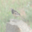

In [32]:
decode_img(img)

In [22]:
output=vae(adjust(torch.Tensor(img)[None, :]).to(device))

In [26]:
i=decode_img(output[0])

array([[[7, 5, 5],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [6, 5, 7]],

       [[0, 0, 0],
        [1, 1, 1],
        [1, 0, 1],
        ...,
        [1, 1, 0],
        [1, 2, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        ...,
        [1, 0, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [2, 0, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [2, 2, 1],
        [0, 0, 0]],

       [[8, 5, 7],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [8, 8, 7]]], dtype=uint8)

In [24]:
from PIL import Image
im = Image.fromarray(np.asarray(img), 'RGB')
im.show()

In [25]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in vae.state_dict():
#     print(param_tensor, "\t", vae.state_dict()[param_tensor].size())

In [52]:
torch.save(vae.state_dict(), "./vae_weights")

In [57]:
!ls -al

total 493396
drwxr-xr-x 1 root root      4096 Nov 11 12:00 .
drwxr-xr-x 1 root root      4096 Nov 11 09:15 ..
drwxr-xr-x 3 2156 1103      4096 Nov 11 09:26 cifar-10-batches-py
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz
drwxr-xr-x 4 root root      4096 Nov  9 14:28 .config
drwxr-xr-x 1 root root      4096 Nov  9 14:29 sample_data
-rw-r--r-- 1 root root 334710673 Nov 11 12:00 vae_weights
